# ДЗ 4. Репетиторы

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import chi2_contingency, mannwhitneyu, boxcox, shapiro, probplot
from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.model_selection import check_cv, cross_val_score, train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, mean_squared_log_error, median_absolute_error, explained_variance_score, max_error
import optuna
from optuna.samplers import TPESampler

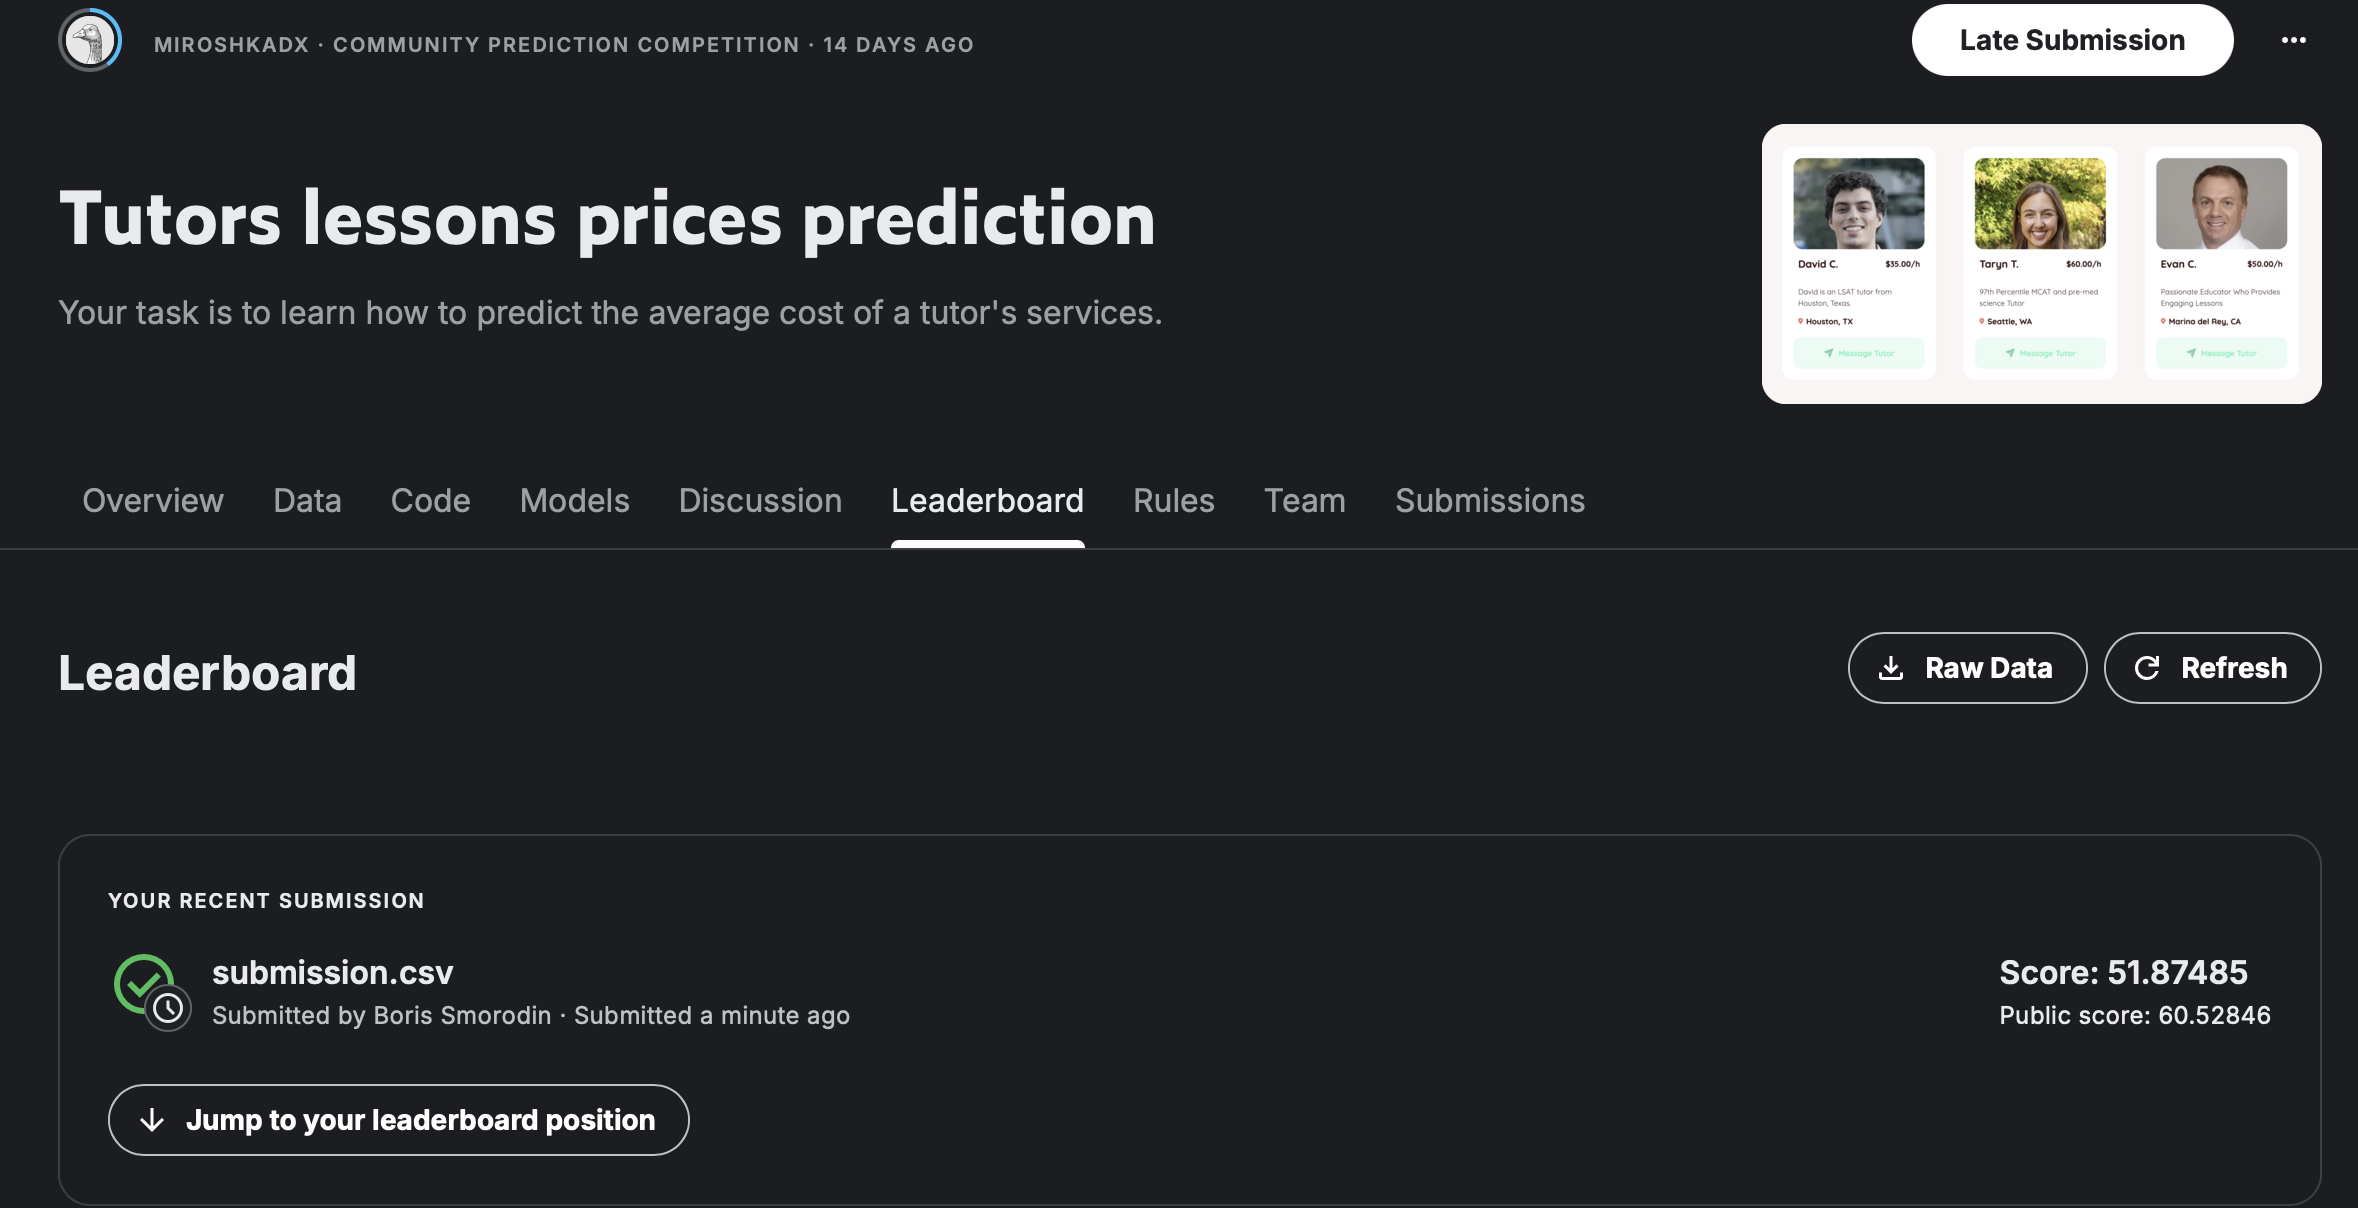

In [5679]:
train = pd.read_excel("homework_4_data/train.xlsx")
test = pd.read_excel("homework_4_data/test.xlsx")

## EDA

In [5680]:
def split_features_due_type(df: pd.DataFrame, dtype) -> list[str]:
    features_list = [column for column in df.columns if isinstance(df.dtypes[column], dtype)]
    return features_list

### Исследуем train

In [5681]:
train.shape

(4548, 28)

In [5682]:
train.head()

Unnamed: 0      предмет                                                ФИО  \
0           0   matematika  Репетитор по математике  Емельянова Марина Вла...   
1           1   matematika  Репетитор по математике  Назарова Анастасия Ан...   
2           2  informatika  Репетитор по информатике Мотроненко Инна Конст...   
3           3   matematika  Репетитор по математике  Логинова Елизавета Ал...   
4           4   matematika  Репетитор по математике  Харланов Олег Викторо...   

                                     tutor_head_tags  tutor_rating  \
0  ['Школьная программа', 'Подготовка к ЕГЭ', 'По...           5.0   
1  ['Школьная программа', 'Подготовка к ЕГЭ', 'По...           4.0   
2  ['Школьная программа', 'Подготовка к ЕГЭ', 'По...           0.0   
3  ['Школьная программа', 'Математический анализ'...           4.0   
4  ['Школьная программа', 'Подготовка к ЕГЭ', 'По...           0.0   

   tutor_reviews                                        description  \
0              2          Репетитор не предоставил о себе дополн...   
1              7          Репетитор не предоставил о себе дополн...   
2              0          Выезд за город: Балашиха-1, Балашиха-2...   
3             19           Здравствуйте! Меня зовут Елизавета, о...   
4              0          Целеустремленный, ориентирован на резу...   

                                     experience_desc  \
0                                                NaN   
1                                                NaN   
2                      Московская Школа (учитель ...   
3                                                NaN   
4                       преподавателем           ...   

                                         Education_1  \
0   Томский государственный университет им. В.В. ...   
1   Вологодский государственный педагогический ун...   
2   Московский городской педагогический университет    
3   Санкт-Петербургский государственный университет    
4   Приазовский государственный технический униве...   

                                    Desc_Education_1  ...  \
0   Год окончания: 1990, Факультет: механико-мате...  ...   
1   Год окончания: 2017, Факультет: факультет при...  ...   
2   Год окончания: 2008, Факультет: Математически...  ...   
3   Год окончания: 2021, Факультет: физический фа...  ...   
4   Год окончания: 2005, Факультет: Энергетически...  ...   

                           status experience Desc_Education_5  \
0   Университетский преподаватель    31 год               NaN   
1          Школьный преподаватель     8 лет               NaN   
2          Школьный преподаватель    11 лет               NaN   
3           Частный преподаватель     5 лет               NaN   
4           Частный преподаватель    19 лет               NaN   

  Desc_Education_6 Education_5 Education_6 Ученая степень 2 Ученое звание 2  \
0              NaN         NaN         NaN              NaN             NaN   
1              NaN         NaN         NaN              NaN             NaN   
2              NaN         NaN         NaN              NaN             NaN   
3              NaN         NaN         NaN              NaN             NaN   
4              NaN         NaN         NaN              NaN             NaN   

                                          categories mean_price  
0  ['Школьники с 5 по 9 класс', 'Школьники с 10 п...  16.666667  
1  ['Школьники с 5 по 9 класс', 'Школьники с 10 п...  11.666667  
2  ['Школьники с 5 по 9 класс', 'Школьники с 10 п...  23.333333  
3  ['Школьники с 1 по 4 класс', 'Школьники с 5 по...   0.116667  
4  ['Школьники с 5 по 9 класс', 'Школьники с 10 п...  16.666667  

[5 rows x 28 columns]

In [5683]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4548 entries, 0 to 4547
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        4548 non-null   int64  
 1   предмет           4548 non-null   object 
 2   ФИО               4548 non-null   object 
 3   tutor_head_tags   4548 non-null   object 
 4   tutor_rating      3959 non-null   float64
 5   tutor_reviews     4548 non-null   int64  
 6   description       4547 non-null   object 
 7   experience_desc   2171 non-null   object 
 8   Education_1       4548 non-null   object 
 9   Desc_Education_1  4472 non-null   object 
 10  Education_2       781 non-null    object 
 11  Desc_Education_2  777 non-null    object 
 12  Education_3       106 non-null    object 
 13  Desc_Education_3  105 non-null    object 
 14  Education_4       16 non-null     object 
 15  Desc_Education_4  16 non-null     object 
 16  Ученая степень 1  76 non-null     object 


In [5684]:
cat_features = split_features_due_type(train, np.dtypes.ObjectDType)
int_features = split_features_due_type(train, np.dtypes.Int64DType)
float_features = split_features_due_type(train, np.dtypes.Float64DType)
train[cat_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4548 entries, 0 to 4547
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   предмет           4548 non-null   object
 1   ФИО               4548 non-null   object
 2   tutor_head_tags   4548 non-null   object
 3   description       4547 non-null   object
 4   experience_desc   2171 non-null   object
 5   Education_1       4548 non-null   object
 6   Desc_Education_1  4472 non-null   object
 7   Education_2       781 non-null    object
 8   Desc_Education_2  777 non-null    object
 9   Education_3       106 non-null    object
 10  Desc_Education_3  105 non-null    object
 11  Education_4       16 non-null     object
 12  Desc_Education_4  16 non-null     object
 13  Ученая степень 1  76 non-null     object
 14  Ученое звание 1   35 non-null     object
 15  status            4535 non-null   object
 16  experience        4523 non-null   object
 17  Desc_Education

In [5685]:
train[cat_features].head()

предмет                                                ФИО  \
0   matematika  Репетитор по математике  Емельянова Марина Вла...   
1   matematika  Репетитор по математике  Назарова Анастасия Ан...   
2  informatika  Репетитор по информатике Мотроненко Инна Конст...   
3   matematika  Репетитор по математике  Логинова Елизавета Ал...   
4   matematika  Репетитор по математике  Харланов Олег Викторо...   

                                     tutor_head_tags  \
0  ['Школьная программа', 'Подготовка к ЕГЭ', 'По...   
1  ['Школьная программа', 'Подготовка к ЕГЭ', 'По...   
2  ['Школьная программа', 'Подготовка к ЕГЭ', 'По...   
3  ['Школьная программа', 'Математический анализ'...   
4  ['Школьная программа', 'Подготовка к ЕГЭ', 'По...   

                                         description  \
0          Репетитор не предоставил о себе дополн...   
1          Репетитор не предоставил о себе дополн...   
2          Выезд за город: Балашиха-1, Балашиха-2...   
3           Здравствуйте! Меня зовут Елизавета, о...   
4          Целеустремленный, ориентирован на резу...   

                                     experience_desc  \
0                                                NaN   
1                                                NaN   
2                      Московская Школа (учитель ...   
3                                                NaN   
4                       преподавателем           ...   

                                         Education_1  \
0   Томский государственный университет им. В.В. ...   
1   Вологодский государственный педагогический ун...   
2   Московский городской педагогический университет    
3   Санкт-Петербургский государственный университет    
4   Приазовский государственный технический униве...   

                                    Desc_Education_1  \
0   Год окончания: 1990, Факультет: механико-мате...   
1   Год окончания: 2017, Факультет: факультет при...   
2   Год окончания: 2008, Факультет: Математически...   
3   Год окончания: 2021, Факультет: физический фа...   
4   Год окончания: 2005, Факультет: Энергетически...   

                                         Education_2  \
0                                                NaN   
1          Череповецкий государственный университет    
2   Московский городской педагогический университ...   
3                                                NaN   
4                                                NaN   

                                    Desc_Education_2  \
0                                                NaN   
1   Год окончания: 2023, Факультет: институт инфо...   
2   Год окончания: 2014, Факультет: Безопасность ...   
3                                                NaN   
4                                                NaN   

                        Education_3  ... Ученое звание 1  \
0                               NaN  ...             NaN   
1                               NaN  ...             NaN   
2   Российская таможенная академия   ...             NaN   
3                               NaN  ...             NaN   
4                               NaN  ...             NaN   

                           status experience Desc_Education_5  \
0   Университетский преподаватель    31 год               NaN   
1          Школьный преподаватель     8 лет               NaN   
2          Школьный преподаватель    11 лет               NaN   
3           Частный преподаватель     5 лет               NaN   
4           Частный преподаватель    19 лет               NaN   

  Desc_Education_6 Education_5 Education_6 Ученая степень 2 Ученое звание 2  \
0              NaN         NaN         NaN              NaN             NaN   
1              NaN         NaN         NaN              NaN             NaN   
2              NaN         NaN         NaN              NaN             NaN   
3              NaN         NaN         NaN              NaN             NaN   
4              NaN         NaN         NaN              NaN             NaN   

      

#### Предварительное исследование experience_desc

In [5686]:
train["experience_desc"][4546]

'                     – полгода            Изначально готовил знакомых,  которым понравился мой подход к обучению, что натолкнуло меня на репетиторство. _x000D_Сам сдал ЕГЭ по информатике на 90 баллов._x000D_Самый высокий балл ученика – 90._x000D_Средний балл учеников – 80.    '

In [5687]:
train["experience_desc"][4526]

'                    Общеобразовательная школа             Учитель математики и информатики с 2017 года _x000D_Репетитор по математике и информатике с 2013 года     '

#### Предварительное исследование tutor_head_tags

In [5688]:
train["tutor_head_tags"].nunique()

353

In [5689]:
train["tutor_head_tags"][4546]

"['Школьная программа', 'Подготовка к ЕГЭ', 'Подготовка к ОГЭ']"

In [5690]:
train["tutor_head_tags"][451]

"['Школьная программа', 'Подготовка к ЕГЭ', 'Подготовка к ОГЭ', 'Подготовка к олимпиадам']"

In [5691]:
train["tutor_head_tags"][3]

"['Школьная программа', 'Математический анализ', 'Подготовка к ЕГЭ', 'Аналитическая геометрия', 'Подготовка к ОГЭ', 'Линейная алгебра', 'Дифференциальные уравнения', 'Теория вероятности и мат. статистика']"

#### Предварительное исследование desc_education

In [5692]:
train["Desc_Education_1"]

0        Год окончания: 1990, Факультет: механико-мате...
1        Год окончания: 2017, Факультет: факультет при...
2        Год окончания: 2008, Факультет: Математически...
3        Год окончания: 2021, Факультет: физический фа...
4        Год окончания: 2005, Факультет: Энергетически...
                              ...                        
4543     Год окончания: 2020, Факультет: физический фа...
4544     Год окончания: 1979, Факультет: Факультет авт...
4545     Год окончания: 2020, Факультет: Информационны...
4546     Год окончания: 2026, Факультет: Институт инфо...
4547     Год окончания: 2026, Факультет: Педагогическо...
Name: Desc_Education_1, Length: 4548, dtype: object

In [5693]:
train["Desc_Education_1"].nunique()

3640

In [5694]:
train["Desc_Education_1"][3]

' Год окончания: 2021, Факультет: физический факультет, Специальность: физика '

In [5695]:
train["Desc_Education_1"][3003]

' Год окончания: 2015, Факультет: Вычислительной математики и кибернетики, Специальность: Прикладная математика и информатика, Квалификация: Бакалавр '

In [5696]:
train["Desc_Education_1"][4527]

' Год окончания: 2024, Факультет: Факультет компьютерных наук, Специальность: Прикладная математика и информатика, Квалификация: Студент '

In [5697]:
target = "mean_price"

#### Предварительно исследование status

In [5698]:
train["status"]

0        Университетский преподаватель
1               Школьный преподаватель
2               Школьный преподаватель
3                Частный преподаватель
4                Частный преподаватель
                     ...              
4543             Частный преподаватель
4544            Школьный преподаватель
4545                           Студент
4546                           Студент
4547                           Студент
Name: status, Length: 4548, dtype: object

In [5699]:
train["status"].nunique()

10

#### Предварительно исследование experience

In [5700]:
train["experience"].unique()

array([' 31 год ', ' 8 лет ', ' 11 лет ', ' 5 лет ', ' 19 лет ',
       ' 7 лет ', ' 27 лет ', ' 9 лет ', ' 38 лет ', ' 28 лет ',
       ' 17 лет ', ' 6 лет ', ' 13 лет ', ' 45 лет ', ' 4 года ',
       ' 3 года ', ' 10 лет ', ' 2 года ', ' 14 лет ', ' 20 лет ',
       ' 18 лет ', ' 32 года ', ' 16 лет ', ' 21 год ', ' 15 лет ',
       ' 12 лет ', ' 1 год ', ' 24 года ', ' 29 лет ', ' 22 года ',
       ' 39 лет ', ' 23 года ', ' 25 лет ', ' 34 года ', nan, ' 33 года ',
       ' 43 года ', ' 36 лет ', ' 40 лет ', ' 26 лет ', ' 41 год ',
       ' 30 лет ', ' 42 года ', ' 37 лет ', ' 35 лет ', ' 47 лет ',
       ' 44 года ', ' 53 года ', ' 55 лет ', ' 68 лет ', ' 48 лет ',
       ' 52 года ', ' 50 лет ', ' 46 лет ', ' 51 год ', ' 54 года '],
      dtype=object)

In [5701]:
train["experience"].mode()

0     4 года 
Name: experience, dtype: object

#### Предварительное исследование description

In [5702]:
train["description"]

0               Репетитор не предоставил о себе дополн...
1               Репетитор не предоставил о себе дополн...
2               Выезд за город: Балашиха-1, Балашиха-2...
3                Здравствуйте! Меня зовут Елизавета, о...
4               Целеустремленный, ориентирован на резу...
                              ...                        
4543            Закончил ННГУ им. Николая Лобачевского...
4544            Я, Травникова Ирина Николаевна, препод...
4545            Готовлю учеников старших классов к сда...
4546            Выпускник медалист, студент РТУ МИРЭА,...
4547            Провожу занятия с детьми  с 2019 года....
Name: description, Length: 4548, dtype: object

In [5703]:
train["description"].mode()[0]

'        Репетитор не предоставил о себе дополнительных сведений    '

In [5704]:
train[train["description"] == '        Репетитор не предоставил о себе дополнительных сведений    '].shape

(1123, 28)

#### Предмет

In [5705]:
train["предмет"].unique()

array(['matematika', 'informatika'], dtype=object)

#### Выводы по предварительному исследованию категориальных признаков

Датасет представляет собой выгрузку из ненормализованной БД и нуждается в обработке. 

Видно, что:
1. Признаки определённых групп могут быть сгруппированы:
    - Education - количественно; можно создать признак:
        - num_of_high_ed - целочисленный
    - Учёная степень; аналогично
    Однако количество репетиторов с 2-мя учёными степенями, как видно из сводки, равняется одному. Это статистически незначимый результат, ввиду чего можно упростить модель, введя признак наличия учёной степени.
2. Важное в контексте задачи поле `experience_desc` заполнялось собственноручно. При этом в данном поле может содержаться информация о нескольких релевантных записях опыта репетитора. Подразумевается подход с выедлением ключевых слов "учитель", "школа", "репетитор", "преподаватель", "вуз", "университет" (на основе лексем) и создание категориальных признаков на основе данного поля. Признаки следующие: 
    - exp_tutor - бинарный
    - exp_teacher - бинарный
    - exp_professor - бинарный
3. Важное в контексте задачи поле `tutor_head_tags` не нормализовано. Следовательно, необходимо выделить из него категории, поскольку их лимитированное количество. Ключевые факторы, на основе которых, как и в предыдущем пункте, будут выделены признаки:
    - tag_oge - бинарный (репетитор готовит к ОГЭ)
    - tag_ege - бинарный (репетитор готовит к ЕГЭ)
    - tag_school - бинарный (репетитор помогает со школьной программой)
    - tag_high - бинарный (репетитор помогает с конкретными дисциплинами в рамках высшего образования). Это наиболее сложный для обработки признак
4. Почти для всех репетиторов наблюдается указание сведений о получении высшего образования:
    - год окончания, по которому можно судить об опыте специалиста и его возрасте, что влияет на цену;
    - специальность и квалификация, что тоже может влиять на цену, однако, эти данные трудно обрабатывать, поскольку заполнялись в свободной форме.
    
    На основании этого боля будет сформирован признак:
    first_high_ed_year - целочисленный; Если год не указан или высшее образование не получено, то будет проставлено значение 0.

5. `status` - станадртный категориальный признак, который после заполнения nan (модой) будет иметь 9 категорий
6. `experince` - подлежит преобразованию в целочисленный признак. Также можно рассмотреть создание на его основе бинарного признака:
    - exp_over_5_years - более 5-ти лет опыта

    Поскольку наиболее часто встречающееся значение меньше 5-ти лет
7. `description`, на мой взгляд, имеет смысл рассматривать только с точки зрения его наличия. Наличие описания напрямую влияет на клиенсткую базу и охваты, позволяя репетитору манипулировать ценой, повышая её более стремительно. Будет создан признак:
    - has_description - бинарный

Такая модель не учитывает некоторых критериев, например, соответствия специальности репетитора его предмету, а также другие моменты, которые можно было бы выделить из текстовых данных при помощи более продвинутого NLP, но для дз сойдёт.

Ниже приведём функции для обработки train и test датасетов соответствующим образом

### Предобработка

#### Суммаризация образования и учёной степени

In [5706]:
def summarize_features(df: pd.DataFrame, feature_tag_inclued: str, feature_tag_uninclude: str) -> pd.DataFrame:
    features = [col for col in df.columns if feature_tag_inclued in col.lower() and feature_tag_uninclude not in col.lower()]
    print(features)
    num_of_high_ed = []
    for i in range(len(df)):
        row = df.loc[i]
        counter = 0
        for feature in features:
            if row[feature] is not np.nan:
                counter += 1
        num_of_high_ed.append(counter)
    df[f"num_of_{feature_tag_inclued}"] = num_of_high_ed
    df = df.drop(columns=features)
    return df
    
    

In [5707]:
train = summarize_features(train, "education", "desc")
train = summarize_features(train, "ученая степень", "звание")

['Education_1', 'Education_2', 'Education_3', 'Education_4', 'Education_5', 'Education_6']
['Ученая степень 1', 'Ученая степень 2']


In [5708]:
train = train.drop(columns=["Unnamed: 0"])

In [5709]:
train.columns

Index(['предмет', 'ФИО', 'tutor_head_tags', 'tutor_rating', 'tutor_reviews',
       'description', 'experience_desc', 'Desc_Education_1',
       'Desc_Education_2', 'Desc_Education_3', 'Desc_Education_4',
       'Ученое звание 1', 'status', 'experience', 'Desc_Education_5',
       'Desc_Education_6', 'Ученое звание 2', 'categories', 'mean_price',
       'num_of_education', 'num_of_ученая степень'],
      dtype='object')

In [5710]:
train = train.drop(columns=[column for column in train.columns if "desc_education" in column.lower() and column.lower() != "desc_education_1"])
train = train.drop(columns=['Ученое звание 1', 'Ученое звание 2'])


#### Опыт работы репетитором, в школе, в вузе

In [5711]:
def exp_desc(df: pd.DataFrame) -> pd.DataFrame:
    feature = "experience_desc"
    exp_tutor_lst = []
    exp_teacher_lst = []
    exp_professor_lst = []
    for i in range(len(df)):
        exp_tutor = False
        exp_teacher = False
        exp_professor = False
        row = df.loc[i]
        if row[feature] is not np.nan:
            s = row[feature].strip().lower()
            if "репет" in s:
                exp_tutor = True
            if "школ" in s or "учит" in s:
                exp_teacher = True
            if "препод" in s or "вуз" in s or "универ" in s or "институт" in s or "высш" in s:
                exp_professor = True
        exp_tutor_lst.append(exp_tutor)
        exp_teacher_lst.append(exp_teacher)
        exp_professor_lst.append(exp_professor)
        
    df["exp_tutor"] = exp_tutor_lst
    df["exp_tutor"] = df["exp_tutor"].astype("Int16")
    df["exp_teacher"] = exp_teacher_lst
    df["exp_teacher"] = df["exp_teacher"].astype("Int16")
    df["exp_professor"] = exp_professor_lst
    df["exp_professor"] = df["exp_professor"].astype("Int16")
    
    df = df.drop(columns=[feature])
    
    return df

In [5712]:
train = exp_desc(train)

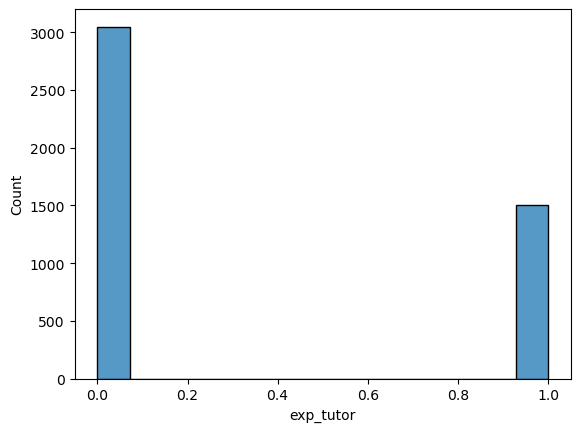

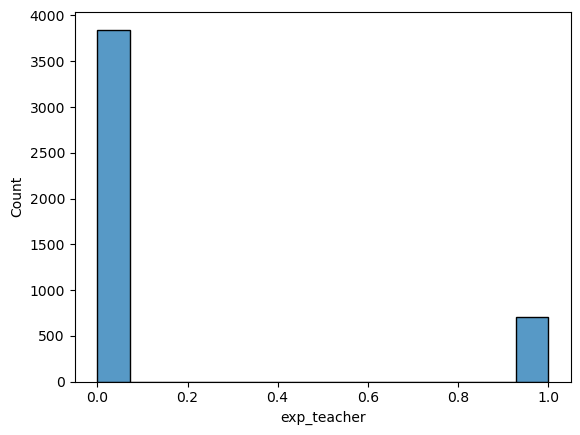

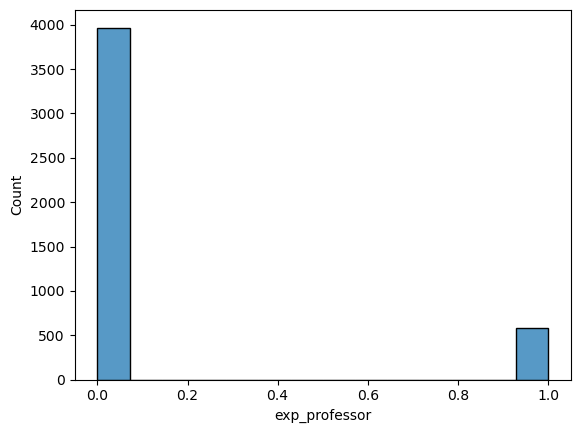

In [5713]:
sns.histplot(train["exp_tutor"])
plt.show()
sns.histplot(train["exp_teacher"])
plt.show()
sns.histplot(train["exp_professor"])
plt.show()

#### tutor_tags

In [5714]:
def tutor_head_tags(df: pd.DataFrame) -> pd.DataFrame:
    feature = "tutor_head_tags"
    tag_school_lst = []
    tag_oge_lst = []
    tag_ege_lst = []
    tag_high_lst = []
    for i in range(len(df)):
        tag_school = False
        tag_oge = False
        tag_ege = False
        tag_high = False
        row = df.loc[i]
        if row[feature] is not np.nan:
            s = row[feature].strip().lower()
            if "школ" in s:
                tag_school = True
            if "огэ" in s:
                tag_oge = True
            if "егэ":
                tag_ege = True
            if "высш" in s or "вуз" in s or "алгебра" in s or "анали" in s:
                tag_high = True
        tag_school_lst.append(tag_school)
        tag_oge_lst.append(tag_oge)
        tag_ege_lst.append(tag_ege)
        tag_high_lst.append(tag_high)
        
    df["tag_school"] = tag_school
    df["tag_school"] = df["tag_school"].astype("Int16")
    df["tag_oge"] = tag_oge
    df["tag_oge"] = df["tag_oge"].astype("Int16")
    df["tag_ege"] = tag_ege
    df["tag_ege"] = df["tag_ege"].astype("Int16")
    df["tag_high"] = tag_high_lst
    df["tag_high"] = df["tag_high"].astype("Int16")
    
    df = df.drop(columns=[feature])
    
    return df

In [5715]:
train = tutor_head_tags(train)

In [5716]:
train["tag_school"].unique()

<IntegerArray>
[1]
Length: 1, dtype: Int16

In [5717]:
train["tag_ege"].unique()

<IntegerArray>
[1]
Length: 1, dtype: Int16

In [5718]:
train["tag_oge"].unique()

<IntegerArray>
[1]
Length: 1, dtype: Int16

- tag_school
- tag oge
- tag ege 

Не изменяются. Следовательно, от данных признаков можно отказаться

In [5719]:
train = train.drop(columns=["tag_oge", "tag_ege", "tag_school"])

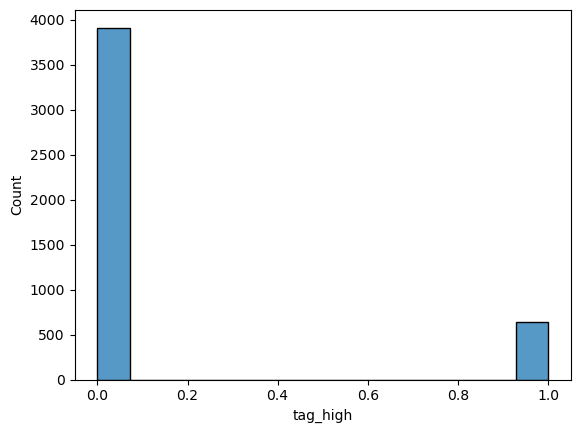

In [5720]:
sns.histplot(train["tag_high"])
plt.show()

#### Год получения 1-го высшего образования. 

Скорректируем подход, указывая разницу между 2025 годом и годом получения образования

In [5721]:
def time_since_first_grade(df: pd.DataFrame) -> pd.DataFrame:
    regexp = r"Год окончания: (\d+)"
    feature = "Desc_Education_1"
    year_difference_arr = []
    for i in range(len(df)):
        row = df.loc[i][feature]
        if row is not np.nan:
            match_obj = re.search(regexp, row)
            try:
                groups = match_obj.groups()
            except:
                print(row)
            year = groups[0]
            try:
                year_difference = 2025 - int(year)
            except:
                print(row)
        else:
            year_difference = np.nan
        
        year_difference_arr.append(year_difference)
            
    df["time_since_first_grade"] = year_difference_arr
    df = df.drop(columns=[feature])
    return df

In [5722]:
train = time_since_first_grade(train)
train

предмет                                                ФИО  \
0      matematika  Репетитор по математике  Емельянова Марина Вла...   
1      matematika  Репетитор по математике  Назарова Анастасия Ан...   
2     informatika  Репетитор по информатике Мотроненко Инна Конст...   
3      matematika  Репетитор по математике  Логинова Елизавета Ал...   
4      matematika  Репетитор по математике  Харланов Олег Викторо...   
...           ...                                                ...   
4543   matematika  Репетитор по математике  Пинчук Всеволод Роман...   
4544  informatika  Репетитор по информатике Травникова Ирина Нико...   
4545  informatika  Репетитор по информатике Савельева Екатерина Ю...   
4546  informatika  Репетитор по информатике Сардарян Артур Роберт...   
4547   matematika  Репетитор по математике  Кузякина Анна Ивановн...   

      tutor_rating  tutor_reviews  \
0              5.0              2   
1              4.0              7   
2              0.0              0   
3              4.0             19   
4              0.0              0   
...            ...            ...   
4543           4.0             11   
4544           0.0              0   
4545           0.0              0   
4546           0.0              0   
4547           0.0              0   

                                            description  \
0             Репетитор не предоставил о себе дополн...   
1             Репетитор не предоставил о себе дополн...   
2             Выезд за город: Балашиха-1, Балашиха-2...   
3              Здравствуйте! Меня зовут Елизавета, о...   
4             Целеустремленный, ориентирован на резу...   
...                                                 ...   
4543          Закончил ННГУ им. Николая Лобачевского...   
4544          Я, Травникова Ирина Николаевна, препод...   
4545          Готовлю учеников старших классов к сда...   
4546          Выпускник медалист, студент РТУ МИРЭА,...   
4547          Провожу занятия с детьми  с 2019 года....   

                              status experience  \
0      Университетский преподаватель    31 год    
1             Школьный преподаватель     8 лет    
2             Школьный преподаватель    11 лет    
3              Частный преподаватель     5 лет    
4              Частный преподаватель    19 лет    
...                              ...        ...   
4543           Частный преподаватель     5 лет    
4544          Школьный преподаватель    30 лет    
4545                         Студент     6 лет    
4546                         Студент     1 год    
4547                         Студент    4 года    

                                             categories  mean_price  \
0     ['Школьники с 5 по 9 класс', 'Школьники с 10 п...   16.666667   
1     ['Школьники с 5 по 9 класс', 'Школьники с 10 п...   11.666667   
2     ['Школьники с 5 по 9 класс', 'Школьники с 10 п...   23.333333   
3     ['Школьники с 1 по 4 класс', 'Школьники с 5 по...    0.116667   
4     ['Школьники с 5 по 9 класс', 'Школьники с 10 п...   16.666667   
...                                                 ...         ...   
4543  ['Школьники с 1 по 4 класс', 'Школьники с 5 по...   16.666667   
4544                       ['Школьники с 5 по 9 класс']   33.333333   
4545  ['Школьники с 5 по 9 класс', 'Школьники с 10 п...   23.333333   
4546  ['Школьники с 5 по 9 класс', 'Школьники с 10 п...    9.722222   
4547  ['Школьники с 1 по 4 класс', 'Школьники с 5 по...   11.111111   

      num_of_education  num_of_ученая степень  exp_tutor  exp_teacher  \
0                    1                      0          0            0   
1                    2                      0          0            0   
2                    3                      0          0            1   
3                    1                      0          0            0   
4                    1                      0          1            1   
...                ...                    ...        ...          ...   
4543          

<Axes: xlabel='time_since_first_grade', ylabel='Count'>

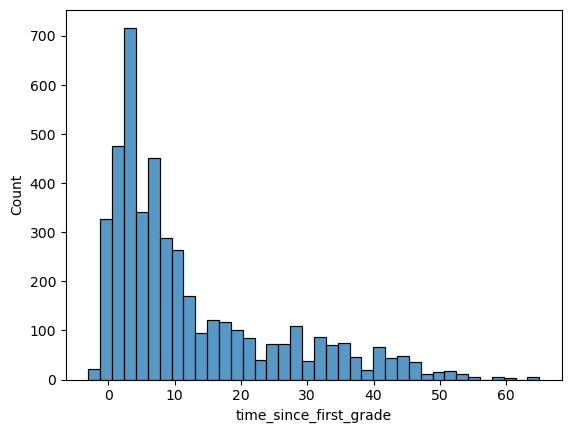

In [5723]:
sns.histplot(train["time_since_first_grade"])

левоассиметричное распределение

#### Описание

In [5724]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4548 entries, 0 to 4547
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   предмет                 4548 non-null   object 
 1   ФИО                     4548 non-null   object 
 2   tutor_rating            3959 non-null   float64
 3   tutor_reviews           4548 non-null   int64  
 4   description             4547 non-null   object 
 5   status                  4535 non-null   object 
 6   experience              4523 non-null   object 
 7   categories              4548 non-null   object 
 8   mean_price              4548 non-null   float64
 9   num_of_education        4548 non-null   int64  
 10  num_of_ученая степень   4548 non-null   int64  
 11  exp_tutor               4548 non-null   Int16  
 12  exp_teacher             4548 non-null   Int16  
 13  exp_professor           4548 non-null   Int16  
 14  tag_high                4548 non-null   

In [5725]:
train[train["description"].isna()]

предмет                                                ФИО  \
3512  matematika  Репетитор по математике  Севидов Андрей Анатол...   

      tutor_rating  tutor_reviews description                  status  \
3512           4.0              5         NaN   Частный преподаватель   

     experience                                         categories  \
3512    15 лет   ['Школьники с 1 по 4 класс', 'Школьники с 5 по...   

      mean_price  num_of_education  num_of_ученая степень  exp_tutor  \
3512   16.666667                 1                      0          0   

      exp_teacher  exp_professor  tag_high  time_since_first_grade  
3512            0              0         0                    19.0

In [5726]:
def has_description(df: pd.DataFrame) -> pd.DataFrame:
    feature = "description"
    df["has_description"] = df[feature].apply(lambda x: x is not np.nan)
    df = df.drop(columns=[feature])
    return df
    

In [5727]:
train = has_description(train)

In [5728]:
train[train["has_description"] == 0]

предмет                                                ФИО  \
3512  matematika  Репетитор по математике  Севидов Андрей Анатол...   

      tutor_rating  tutor_reviews                  status experience  \
3512           4.0              5   Частный преподаватель    15 лет    

                                             categories  mean_price  \
3512  ['Школьники с 1 по 4 класс', 'Школьники с 5 по...   16.666667   

      num_of_education  num_of_ученая степень  exp_tutor  exp_teacher  \
3512                 1                      0          0            0   

      exp_professor  tag_high  time_since_first_grade  has_description  
3512              0         0                    19.0            False

<Axes: xlabel='has_description', ylabel='Count'>

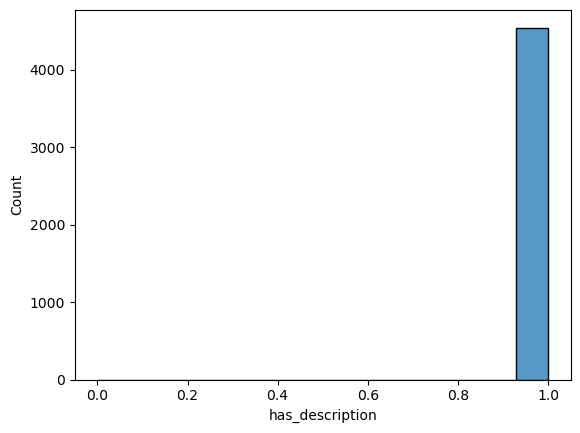

In [5729]:
sns.histplot(train["has_description"])

Видно, что признак не является релевантным. Применять сложное NLP не будем. 

In [5730]:
train = train.drop(columns=["has_description"])

#### Опыт преподавания

Подход был пересмотрен. Будет произведена генерация признака на основе критерия превышения исходного значения моды, но уже после заполнения пустых значений. На данном этапе будет произведено преобразование в целочисленный тип

In [5731]:
def exp_int(df: pd.DataFrame) -> pd.DataFrame:
    feature = "experience"
    df[feature] = df[feature].apply(lambda x: int(x.split()[0]) if x is not np.nan else np.nan)
    return df


In [5732]:
train = exp_int(train)

In [5733]:
train = train.drop(columns="ФИО")

#### Categories 

создадим набор бинарных признаков по каждой категории

In [5734]:
train["categories"][0]

"['Школьники с 5 по 9 класс', 'Школьники с 10 по 11 класс, студенты колледжей и техникумов, абитуриенты']"

In [5735]:
import ast

def client_cats(df: pd.DataFrame) -> pd.DataFrame:
    feature = "categories"
    categories = set()
    for i in range(len(df)):
        row = df.loc[i]
        cats: list[str] = ast.literal_eval(row[feature])
        for cat in cats:
            if ", " in cat:
                inner_cats = cat.split(", ")
                for inner_cat in inner_cats:
                    categories.add(inner_cat)
            else:
                categories.add(cat)
                
    return categories
        

In [5736]:
print(len(client_cats(train)))
print(len(client_cats(test)))
print(client_cats(train) == client_cats(test))

19
19
False


Как видно, категории расходятся для test и train. Вычислим, каких где нет.

In [5737]:
print(client_cats(train) - client_cats(test))
print(client_cats(test) - client_cats(train))

{'Взрослые кроме абитуриентов и студентов группа'}
{'Студенты университетов группа'}


In [5738]:
sorted(client_cats(train))

['Взрослые кроме абитуриентов и студентов',
 'Взрослые кроме абитуриентов и студентов в паре',
 'Взрослые кроме абитуриентов и студентов группа',
 'Дошкольники',
 'Дошкольники в паре',
 'Дошкольники группа',
 'Студенты университетов',
 'Студенты университетов в паре',
 'Школьники с 1 по 4 класс',
 'Школьники с 1 по 4 класс в паре',
 'Школьники с 1 по 4 класс группа',
 'Школьники с 10 по 11 класс',
 'Школьники с 5 по 9 класс',
 'Школьники с 5 по 9 класс в паре',
 'Школьники с 5 по 9 класс группа',
 'абитуриенты',
 'абитуриенты в паре',
 'абитуриенты группа',
 'студенты колледжей и техникумов']

Как видно, категории делятся по:
- статусу учников (школьники, абитуриенты и т.д.)
- возможности репетитора проводить групповые занятия

Оба этих критерия напрямую влияют на стоимость занятия (вывод, исходя из знаний о доменной области). Например, репетитор, занимающийся с абитуриентами в среднем зарабатывает больше репетитора, занимающегося со школьниками младших классов. Однако, если он продит групповые занятия, то цена для одного его ученика может быть сопоставима с ценой учеников-школьников при условии, что второй репетитор проводит только индивидуальные занятия. 

Таким образом, в идеале нужно выделить следующий набор признаков:
1. Бинарный признак по статусу: 
    - Взрослые кроме абитуриентов и студентов;
    - Дошкольники;
    - Студенты университетов;
    - Школьники с 1 по 4 класс;
    - Школьники с 10 по 11 класс;
    - Школьники с 5 по 9 класс;
    - абитуриенты;
    - студенты колледжей и техникумов.
2. Бинарный признак, указывающий на возможность проведения парных и групповых занятий. Для упрощения скажем, что если хотя бы в одной категории встречается такой признак, то он будет справедлив и для остальных. По крайней, мере, на среднюю цену занятия он повлияет, так что гипотеза о предиктивной силе признака в таком толковании может быть жизнеспособна

Также отметим, что такой подход решает проблему с наличием неповторяющихся признаков в train и test, поскольку они отличаются именно по фактору, указаывающему на индивидуальный/групповой характер занятий.

Также вспомним, что в категориях нет пустых значений.

In [5739]:
def categories_feature_extraction(df: pd.DataFrame) -> pd.DataFrame:
    feature = "categories"
    status_features = [
        "Взрослые кроме абитуриентов и студентов",
        "Дошкольники",
        "Студенты университетов",
        "Школьники с 1 по 4 класс",
        "Школьники с 10 по 11 класс",
        "Школьники с 5 по 9 класс",
        "абитуриенты",
        "студенты колледжей и техникумов",
    ]
    pair_feature = "pair_possible"
    pair_keyword = "в паре"
    group_feature = "group_possible"
    group_keyword = "группа"
    
    global_status_dict = {status: [] for status in status_features}
    global_status_dict.update({group_feature: [], pair_feature: []})
    
    for i in range(len(df)):
        row = df.loc[i]
        pair_flag = False
        group_flag = False
        status_dict = {status: False for status in status_features}
        categories = set()
        cats: list[str] = ast.literal_eval(row[feature])
        for cat in cats:
            if ", " in cat:
                inner_cats = cat.split(", ")
                for inner_cat in inner_cats:
                    categories.add(inner_cat)
            else:
                categories.add(cat)
                
        for item in categories:
            for key in status_dict:
                if key in item:
                    status_dict[key] = True
            if pair_keyword in item:
                pair_flag = True
            if group_keyword in item:
                group_flag = True
                
        status_dict.update({group_feature: group_flag, pair_feature: pair_flag})
        for key in status_dict:
            global_status_dict[key].append(status_dict[key])
            
    for key in global_status_dict:
        df[key] = global_status_dict[key]
        df[key] = df[key].astype("Int16")
        
    df = df.drop(columns=feature)

    return df

In [5740]:
train = categories_feature_extraction(train)

#### Статус

In [5741]:
train["status"].unique()

array([' Университетский преподаватель', ' Школьный преподаватель',
       ' Частный преподаватель', ' Студент',
       ' Аспирант или ординатор очной формы обучения', nan,
       ' Университетский преподаватель, Школьный преподаватель',
       ' Аспирант или ординатор очной формы обучения, Частный преподаватель',
       ' Частный преподаватель, Студент',
       ' Университетский преподаватель, Аспирант или ординатор очной формы обучения',
       ' Школьный преподаватель, Аспирант или ординатор очной формы обучения'],
      dtype=object)

In [5742]:
train["status"].mode()

0     Частный преподаватель
Name: status, dtype: object

Как видно, статус содержит пустые значения. Необходимо заполнить их, чтобы проводить выделение признаков. Сделаем это далее.

Будем заполнять модой.

Саму обработку проведём по следующему алгоритму:
1. 

Основная предобработка завершена. Подвергнем test всем этим преобразованиям.

In [5743]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1516 entries, 0 to 1515
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        1516 non-null   int64  
 1   предмет           1516 non-null   object 
 2   ФИО               1516 non-null   object 
 3   tutor_head_tags   1516 non-null   object 
 4   tutor_rating      1516 non-null   int64  
 5   tutor_reviews     1516 non-null   int64  
 6   description       1515 non-null   object 
 7   experience_desc   757 non-null    object 
 8   Education_1       1516 non-null   object 
 9   Desc_Education_1  1498 non-null   object 
 10  Education_2       286 non-null    object 
 11  Desc_Education_2  285 non-null    object 
 12  Education_3       34 non-null     object 
 13  Desc_Education_3  34 non-null     object 
 14  Education_4       3 non-null      object 
 15  Desc_Education_4  3 non-null      object 
 16  Ученая степень 1  20 non-null     object 


In [5744]:
test = summarize_features(test, "education", "desc")
test = summarize_features(test, "ученая степень", "звание")
test = test.drop(columns="Unnamed: 0")
test = test.drop(columns=[column for column in test.columns if "desc_education" in column.lower() and column.lower() != "desc_education_1"])
test = test.drop(columns=['Ученое звание 1', 'Ученое звание 2'])
test = exp_desc(test)
test = tutor_head_tags(test)
test = test.drop(columns=["tag_oge", "tag_ege", "tag_school"])
test = time_since_first_grade(test)
test = has_description(test)
test = test.drop(columns="has_description")
test = exp_int(test)
test = test.drop(columns="ФИО")
test = categories_feature_extraction(test)

['Education_1', 'Education_2', 'Education_3', 'Education_4', 'Education_5', 'Education_6']
['Ученая степень 1', 'Ученая степень 2']


In [5745]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1516 entries, 0 to 1515
Data columns (total 22 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   предмет                                  1516 non-null   object 
 1   tutor_rating                             1516 non-null   int64  
 2   tutor_reviews                            1516 non-null   int64  
 3   status                                   1513 non-null   object 
 4   experience                               1506 non-null   float64
 5   num_of_education                         1516 non-null   int64  
 6   num_of_ученая степень                    1516 non-null   int64  
 7   exp_tutor                                1516 non-null   Int16  
 8   exp_teacher                              1516 non-null   Int16  
 9   exp_professor                            1516 non-null   Int16  
 10  tag_high                                 1516 no

In [5746]:
train["tutor_rating"].unique()

array([ 5.,  4.,  0., nan,  3.,  2.,  1.])

In [5747]:
train["status"].unique()

array([' Университетский преподаватель', ' Школьный преподаватель',
       ' Частный преподаватель', ' Студент',
       ' Аспирант или ординатор очной формы обучения', nan,
       ' Университетский преподаватель, Школьный преподаватель',
       ' Аспирант или ординатор очной формы обучения, Частный преподаватель',
       ' Частный преподаватель, Студент',
       ' Университетский преподаватель, Аспирант или ординатор очной формы обучения',
       ' Школьный преподаватель, Аспирант или ординатор очной формы обучения'],
      dtype=object)

### Исследование и обрабокта данных

In [5748]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4548 entries, 0 to 4547
Data columns (total 23 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   предмет                                  4548 non-null   object 
 1   tutor_rating                             3959 non-null   float64
 2   tutor_reviews                            4548 non-null   int64  
 3   status                                   4535 non-null   object 
 4   experience                               4523 non-null   float64
 5   mean_price                               4548 non-null   float64
 6   num_of_education                         4548 non-null   int64  
 7   num_of_ученая степень                    4548 non-null   int64  
 8   exp_tutor                                4548 non-null   Int16  
 9   exp_teacher                              4548 non-null   Int16  
 10  exp_professor                            4548 no

План:

1. Заполнить пустые значения следующим образом:
    - Опыт работы - медиана
    - Рейтинг - 0 там, где не указано
    - время с получения первого диплома - мода

2. Проанализировать признаки. Провести:
    - анализ распределений признаков
    - первичные тесты для определения значимости признаков

3. (при необходимости) Feature Enineering

#### Пустые значения

In [5749]:
si_exp = SimpleImputer(missing_values=np.nan, strategy="median")
si_mode = SimpleImputer(missing_values=np.nan, strategy="most_frequent")

mode_features = ["time_since_first_grade", "status"]
zero_features = ["tutor_rating"]
median_features = ["experience"]

train[mode_features] = si_mode.fit_transform(train[mode_features])
train[median_features] = si_exp.fit_transform(train[median_features])
train[zero_features] = train[zero_features].fillna(value=0)

test[mode_features] = si_mode.fit_transform(test[mode_features])
test[median_features] = si_exp.fit_transform(test[median_features])
test[zero_features] = test[zero_features].fillna(value=0)


##### Выделение признаков из status

<Axes: >

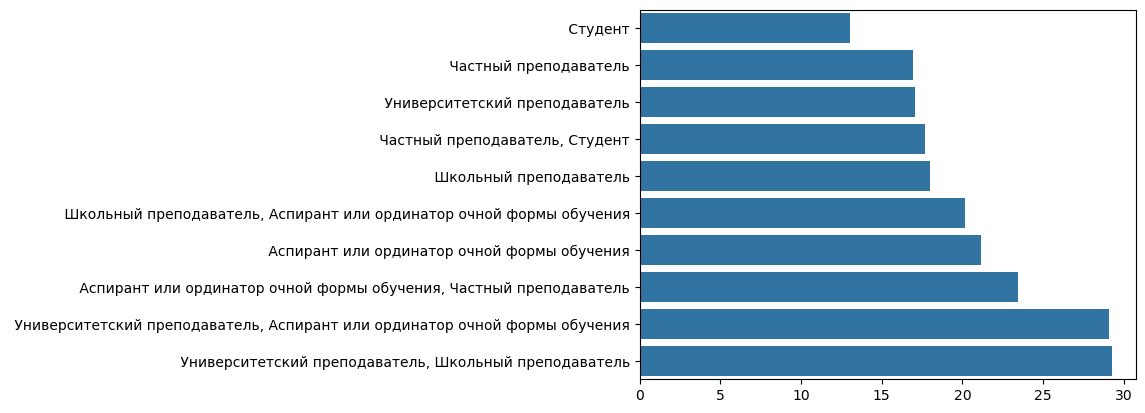

In [5750]:
status_dct = {}

for status in train["status"].unique():
    status_dct.setdefault(status, train[train["status"] == status]["mean_price"].mean())
    
status_dct_sorted = dict(sorted(status_dct.items(), key=lambda x: x[1]))
sns.barplot(status_dct_sorted, orient="y")

In [5751]:
status_dct_ordinal = {list(status_dct_sorted.keys())[i]: i for i in range(len(list(status_dct_sorted.keys())))}

In [5752]:
status_dct_ordinal

{' Студент': 0,
 ' Частный преподаватель': 1,
 ' Университетский преподаватель': 2,
 ' Частный преподаватель, Студент': 3,
 ' Школьный преподаватель': 4,
 ' Школьный преподаватель, Аспирант или ординатор очной формы обучения': 5,
 ' Аспирант или ординатор очной формы обучения': 6,
 ' Аспирант или ординатор очной формы обучения, Частный преподаватель': 7,
 ' Университетский преподаватель, Аспирант или ординатор очной формы обучения': 8,
 ' Университетский преподаватель, Школьный преподаватель': 9}

In [5753]:
train["status"] = train["status"].apply(lambda x: status_dct_ordinal.get(x))
test["status"] = test["status"].apply(lambda x: status_dct_ordinal.get(x))

In [5754]:
train["status"]

0       2
1       4
2       4
3       1
4       1
       ..
4543    1
4544    4
4545    0
4546    0
4547    0
Name: status, Length: 4548, dtype: int64

Провели ординал энкодинг руками. А почему бы и нет?

In [5755]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4548 entries, 0 to 4547
Data columns (total 23 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   предмет                                  4548 non-null   object 
 1   tutor_rating                             4548 non-null   float64
 2   tutor_reviews                            4548 non-null   int64  
 3   status                                   4548 non-null   int64  
 4   experience                               4548 non-null   float64
 5   mean_price                               4548 non-null   float64
 6   num_of_education                         4548 non-null   int64  
 7   num_of_ученая степень                    4548 non-null   int64  
 8   exp_tutor                                4548 non-null   Int16  
 9   exp_teacher                              4548 non-null   Int16  
 10  exp_professor                            4548 no

In [5756]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1516 entries, 0 to 1515
Data columns (total 22 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   предмет                                  1516 non-null   object 
 1   tutor_rating                             1516 non-null   int64  
 2   tutor_reviews                            1516 non-null   int64  
 3   status                                   1515 non-null   float64
 4   experience                               1516 non-null   float64
 5   num_of_education                         1516 non-null   int64  
 6   num_of_ученая степень                    1516 non-null   int64  
 7   exp_tutor                                1516 non-null   Int16  
 8   exp_teacher                              1516 non-null   Int16  
 9   exp_professor                            1516 non-null   Int16  
 10  tag_high                                 1516 no

In [5757]:
train.status.unique()

array([2, 4, 1, 0, 6, 9, 7, 3, 8, 5])

#### Распределения признаков

In [5758]:
train["time_since_first_grade"] = train["time_since_first_grade"].astype("Int16")
test["time_since_first_grade"] = test["time_since_first_grade"].astype("Int16")

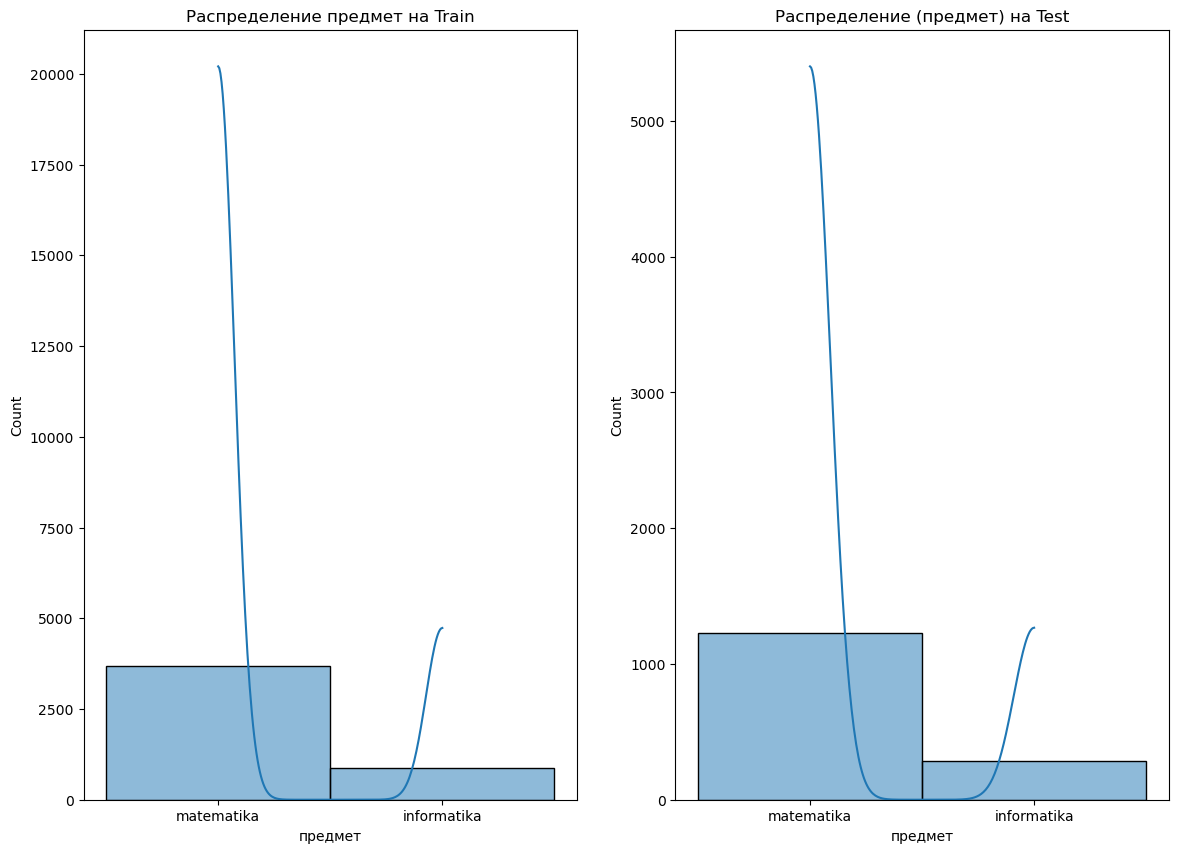

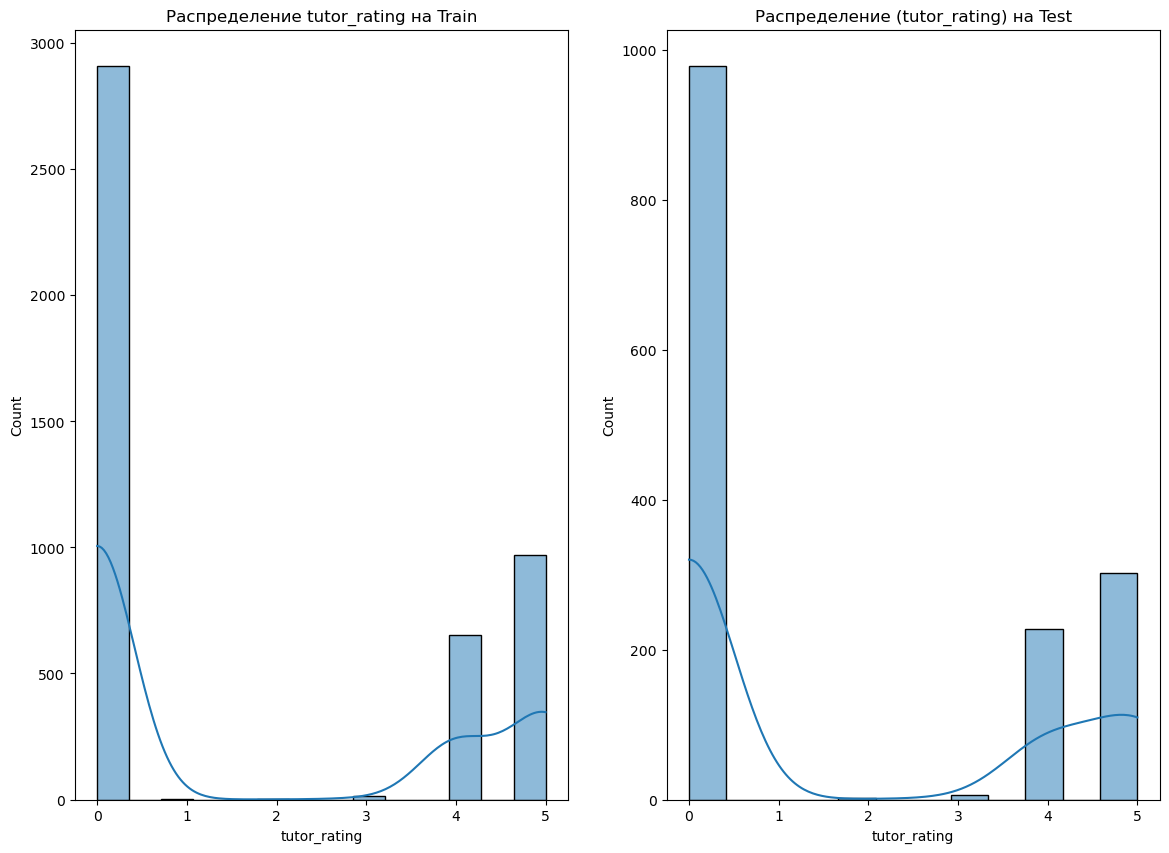

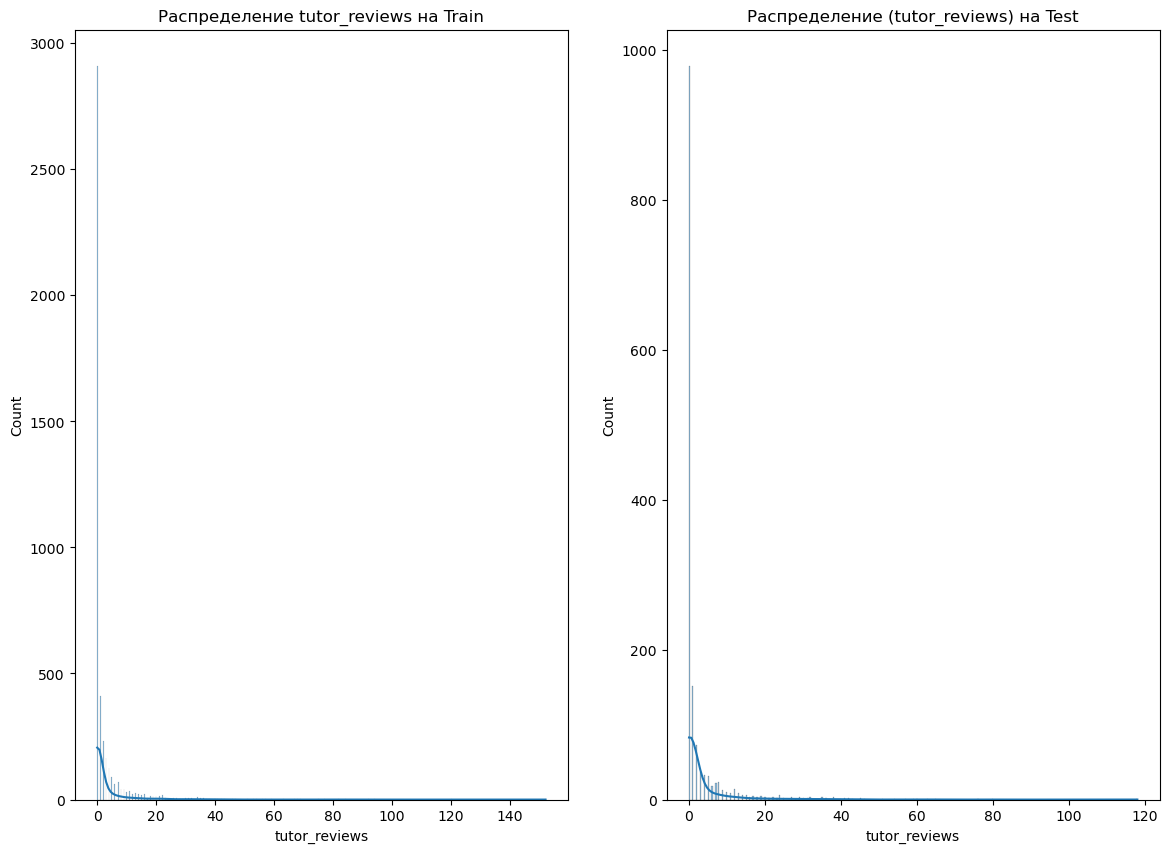

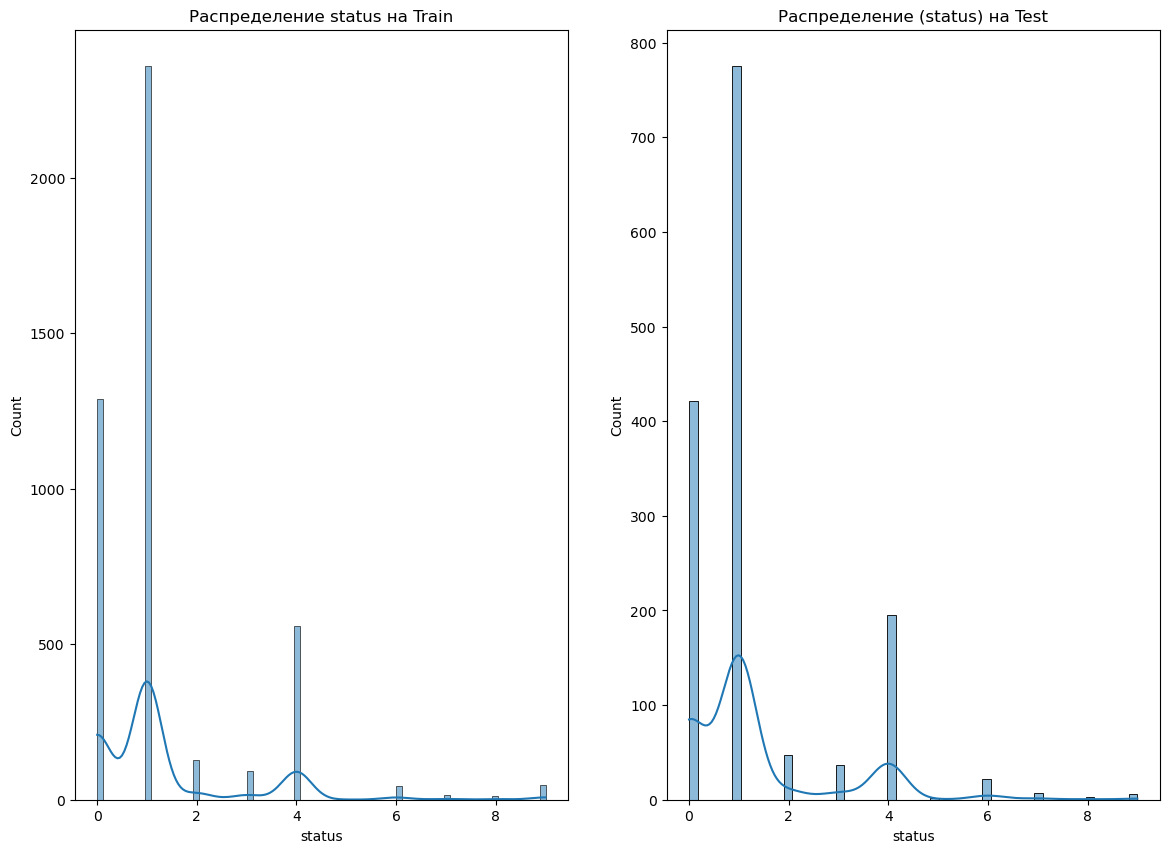

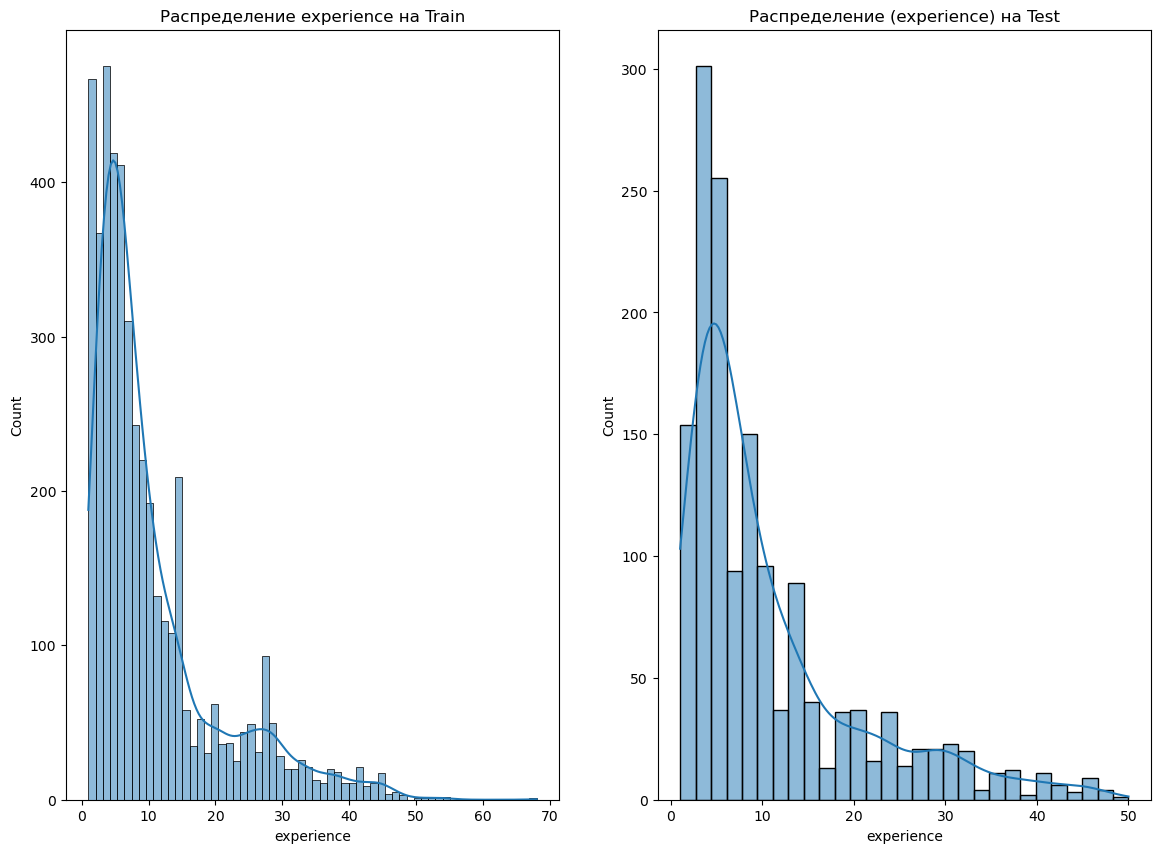

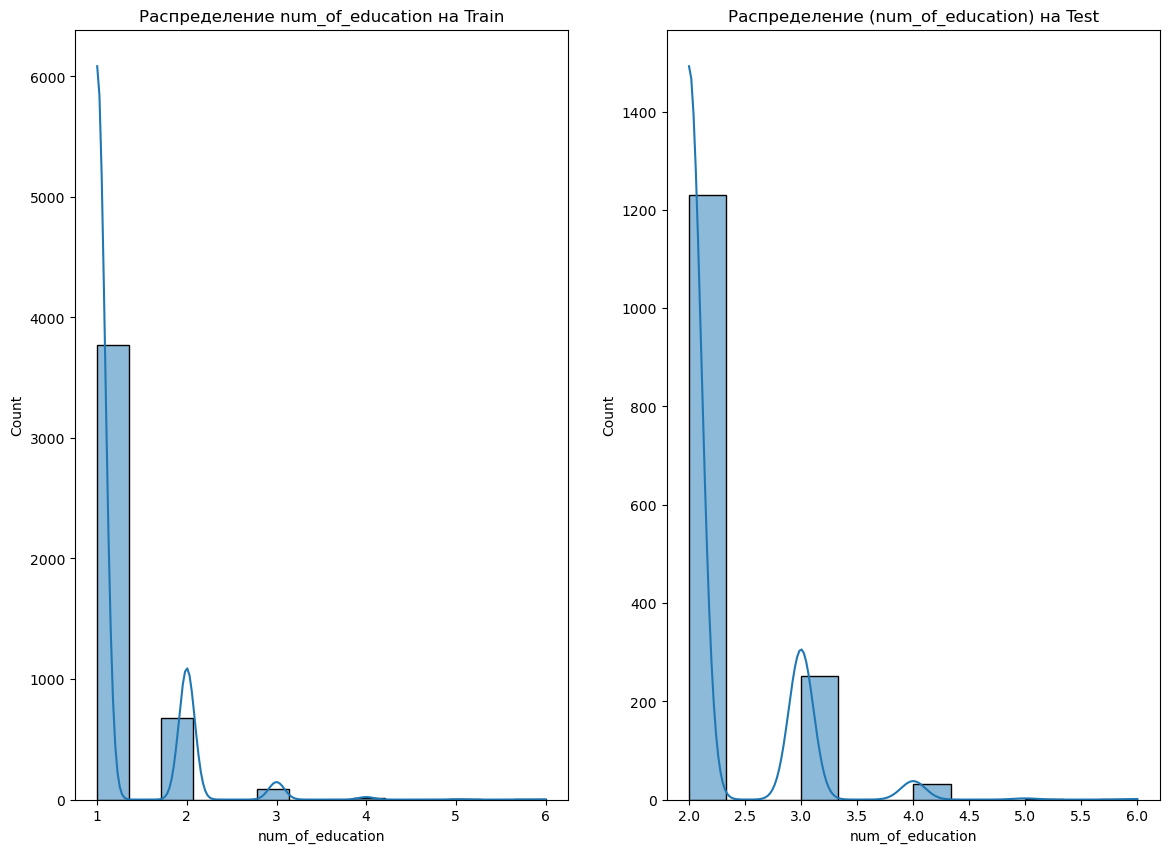

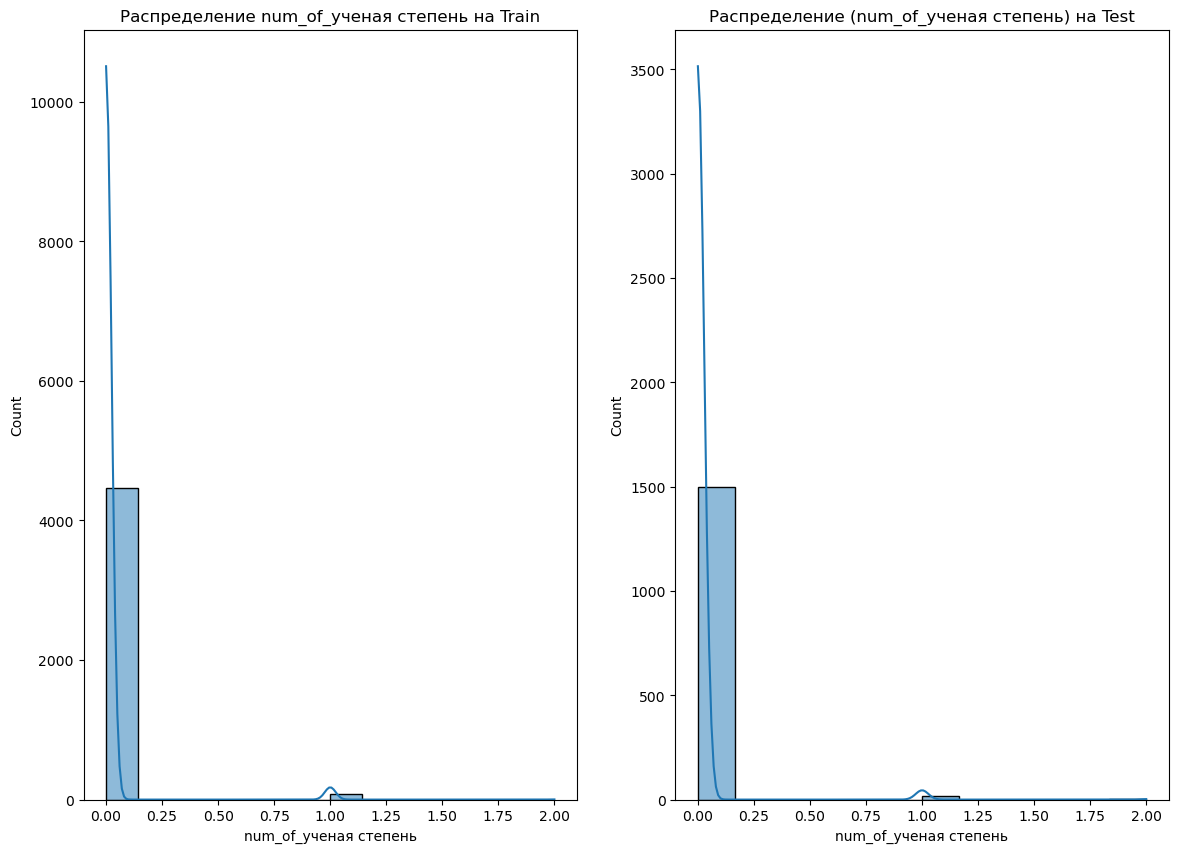

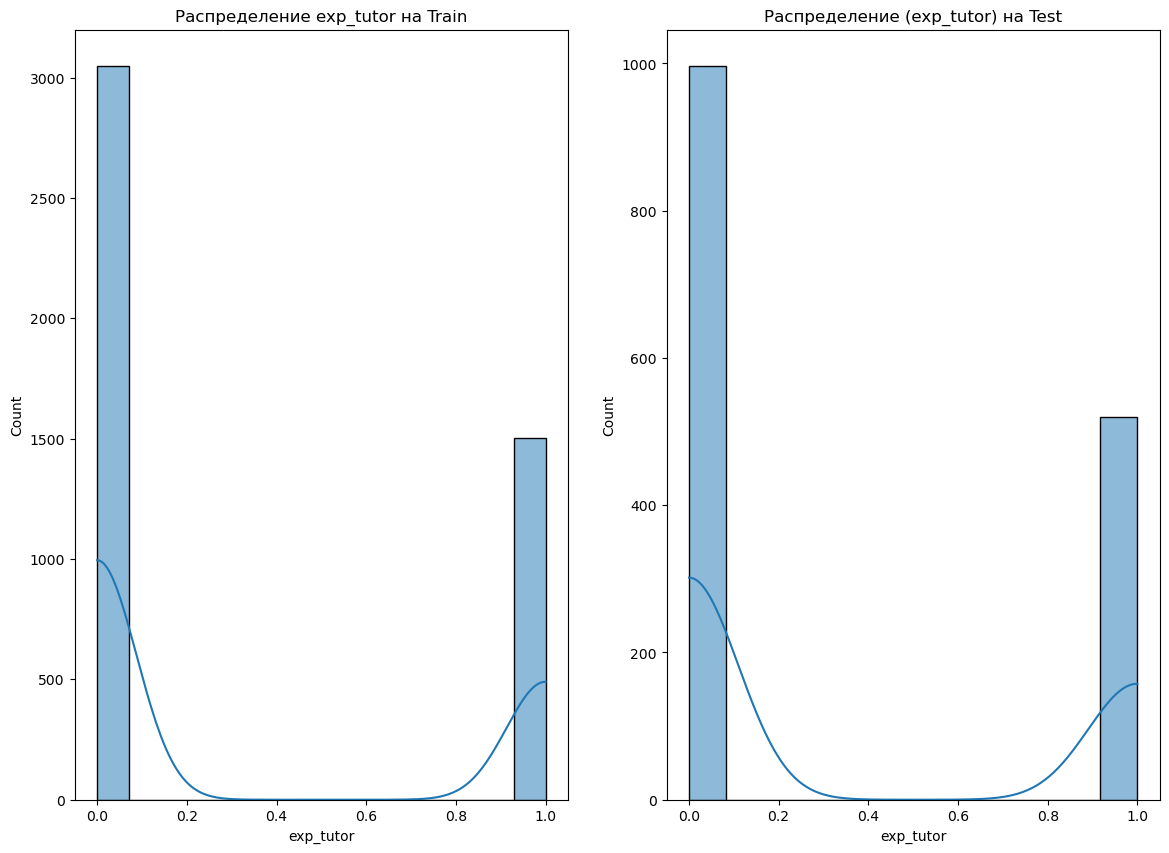

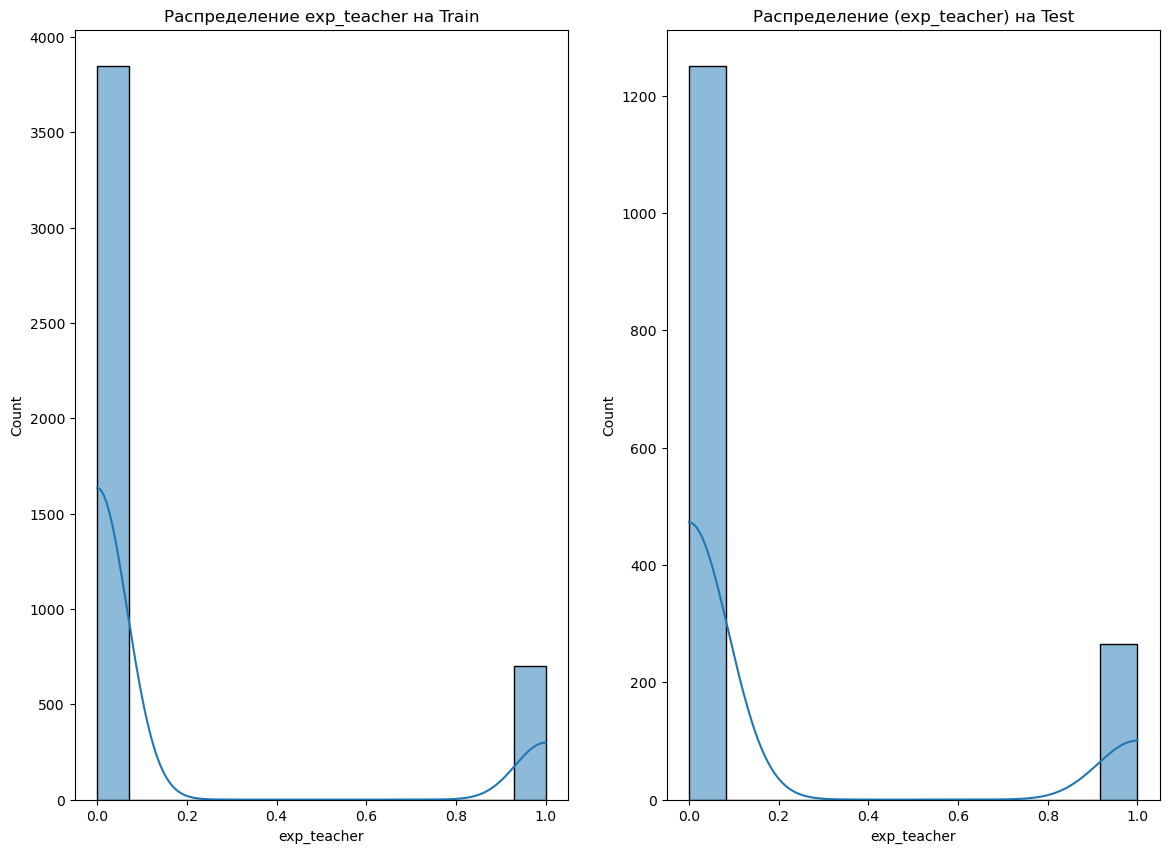

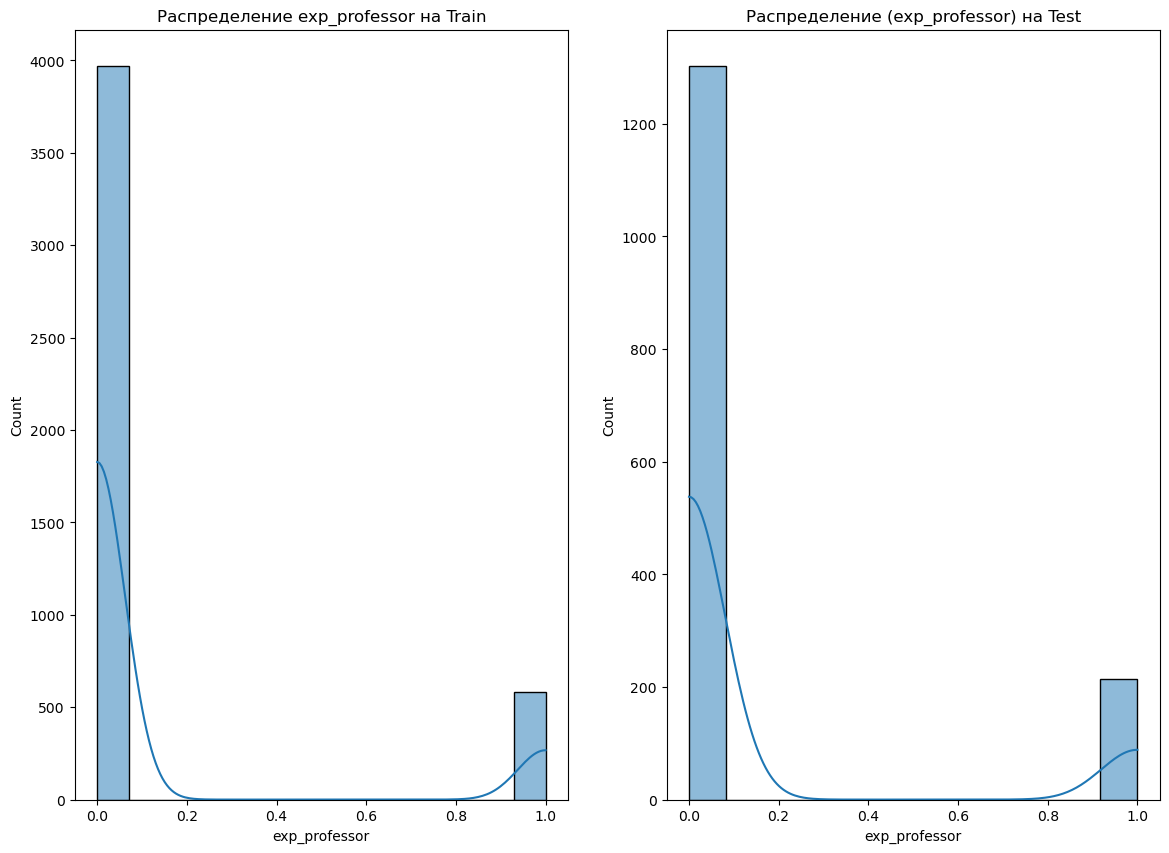

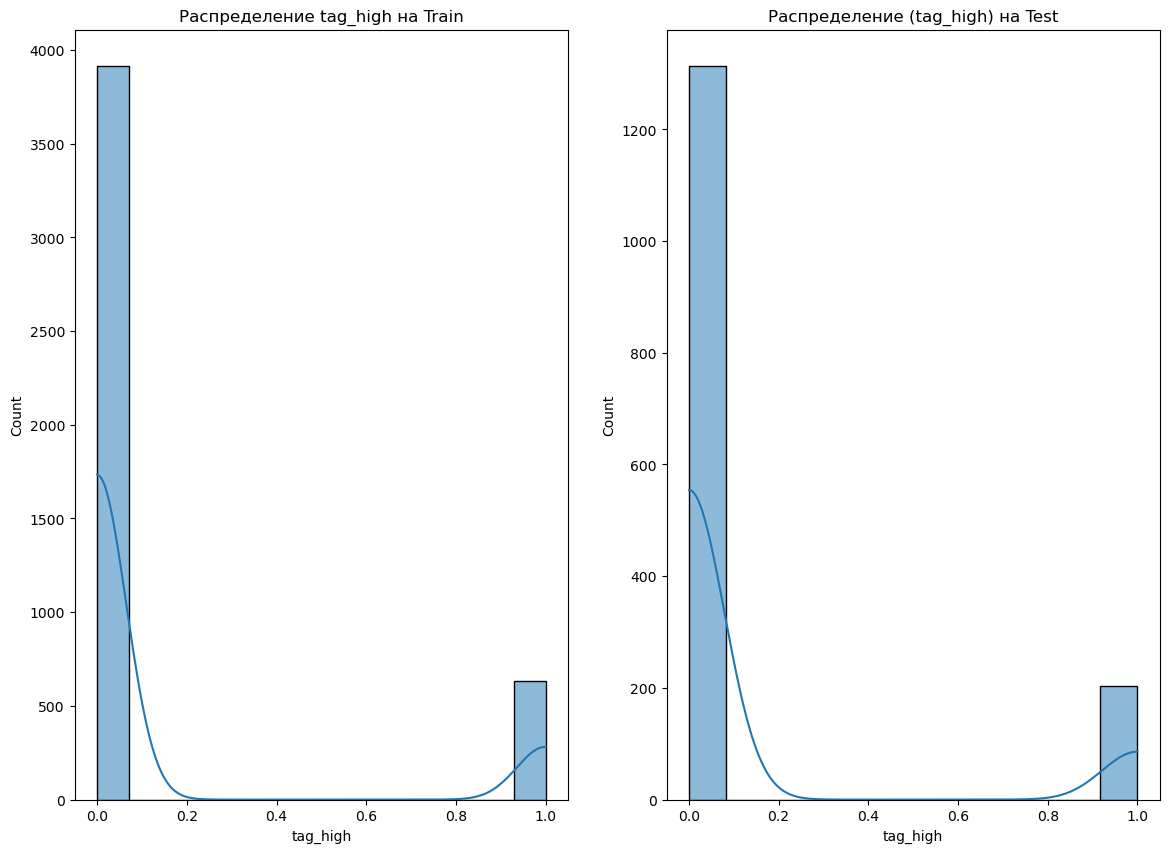

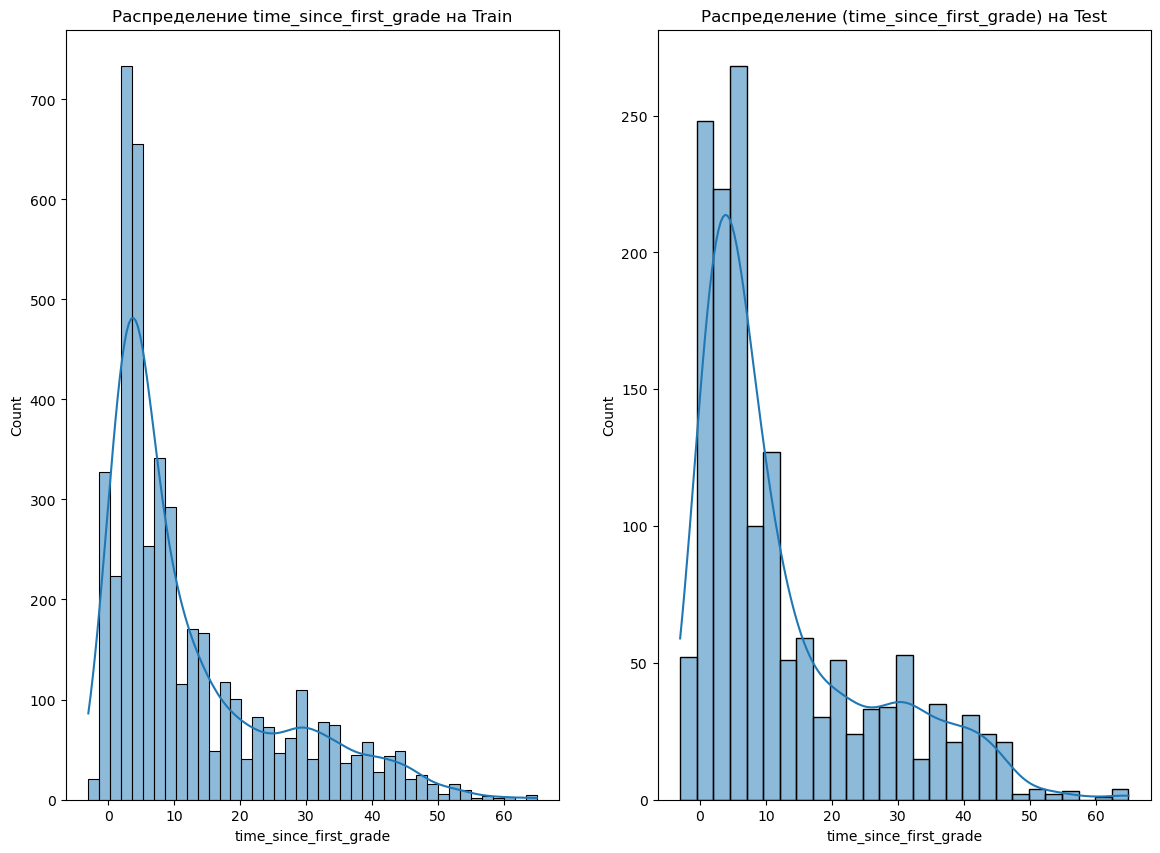

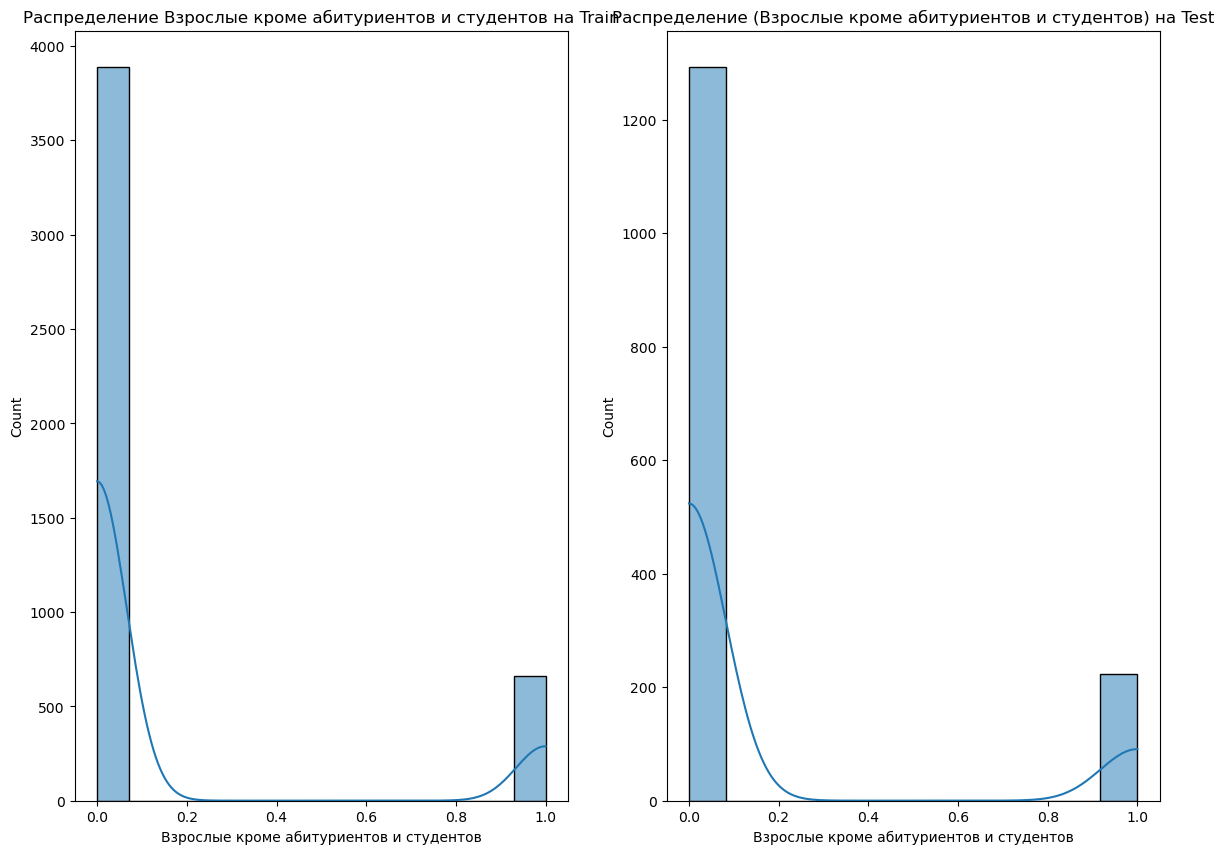

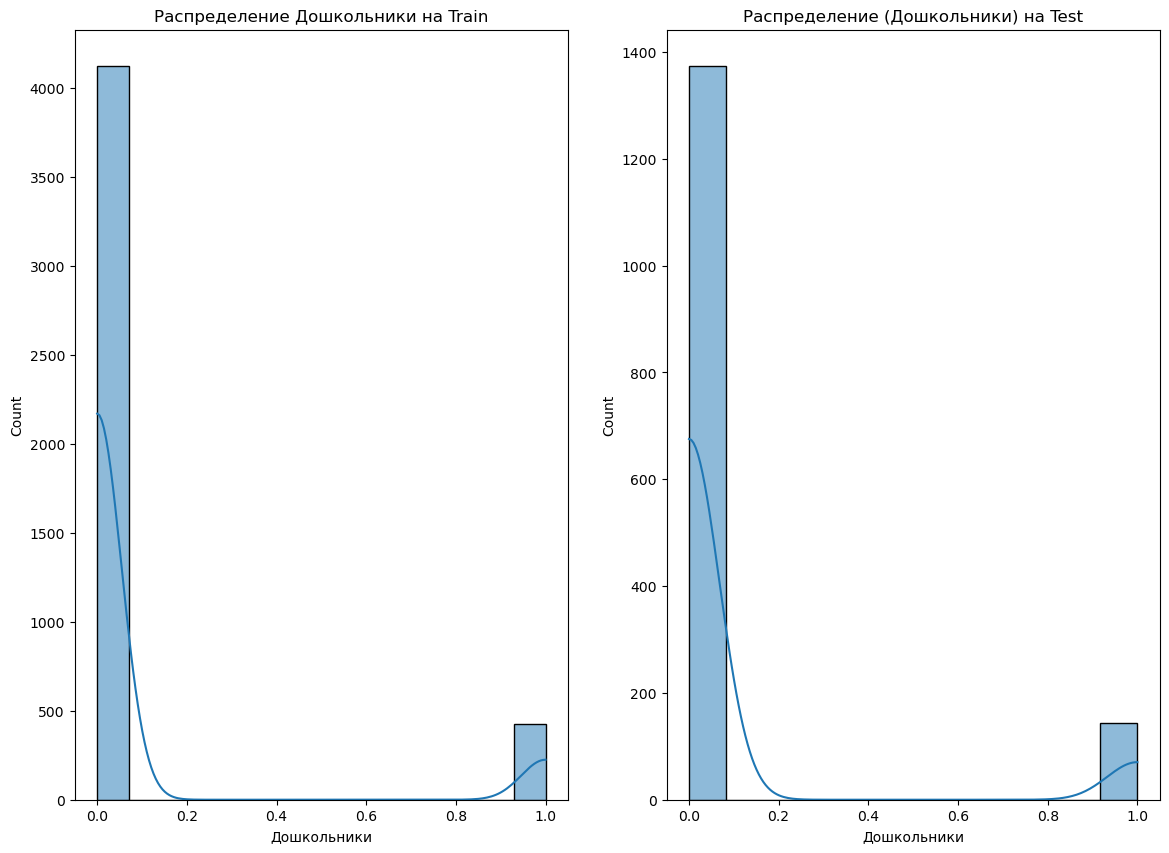

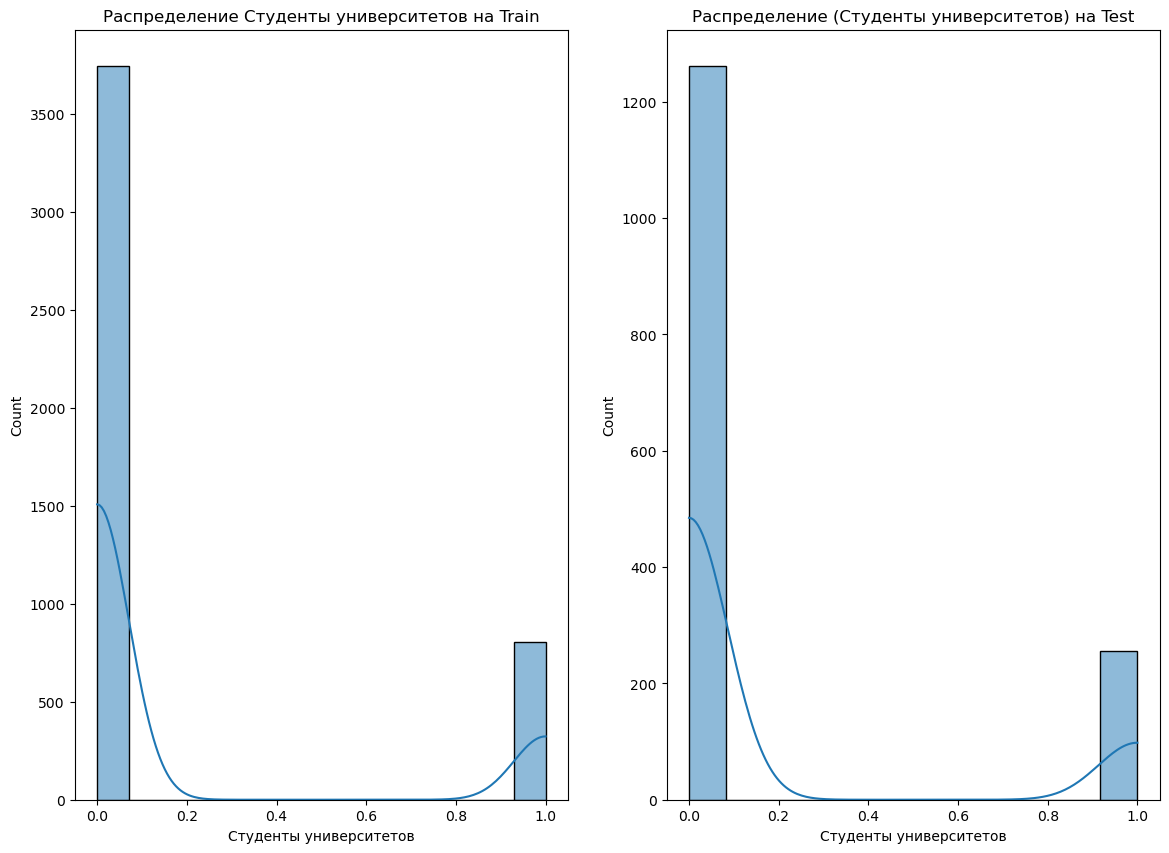

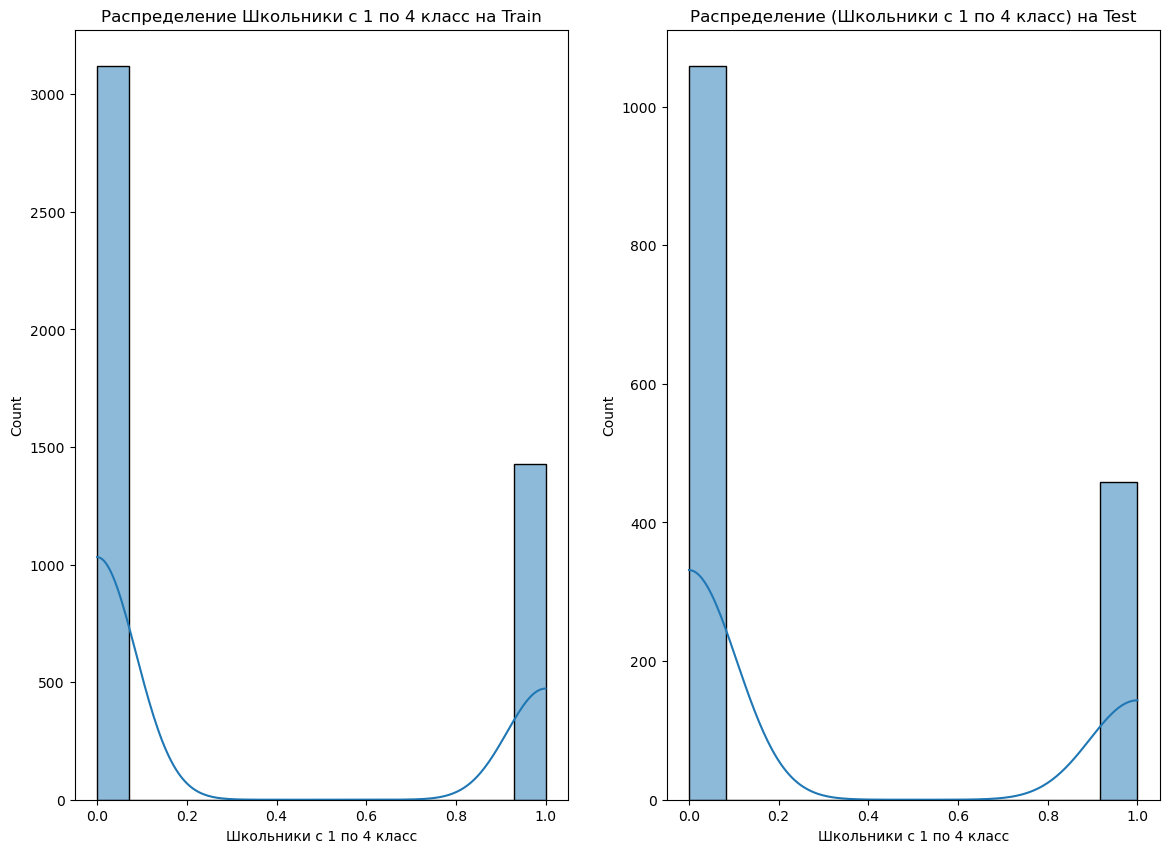

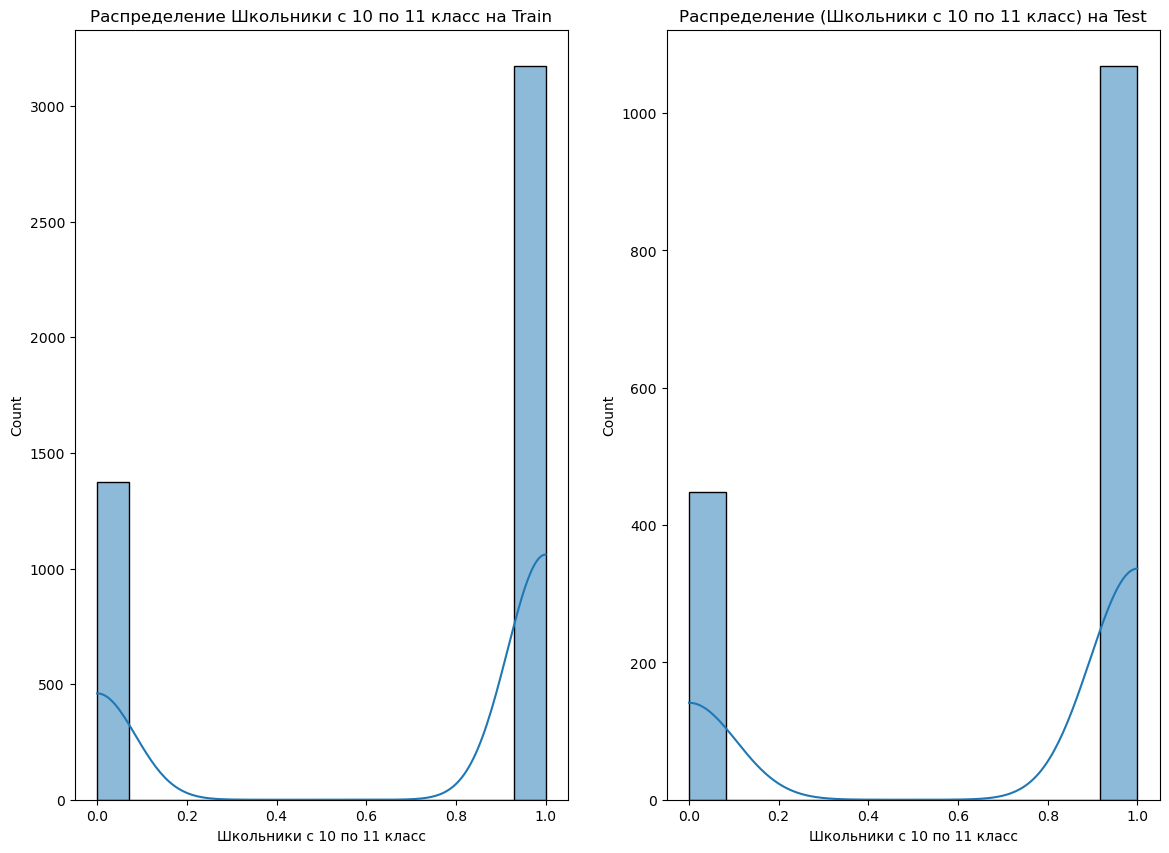

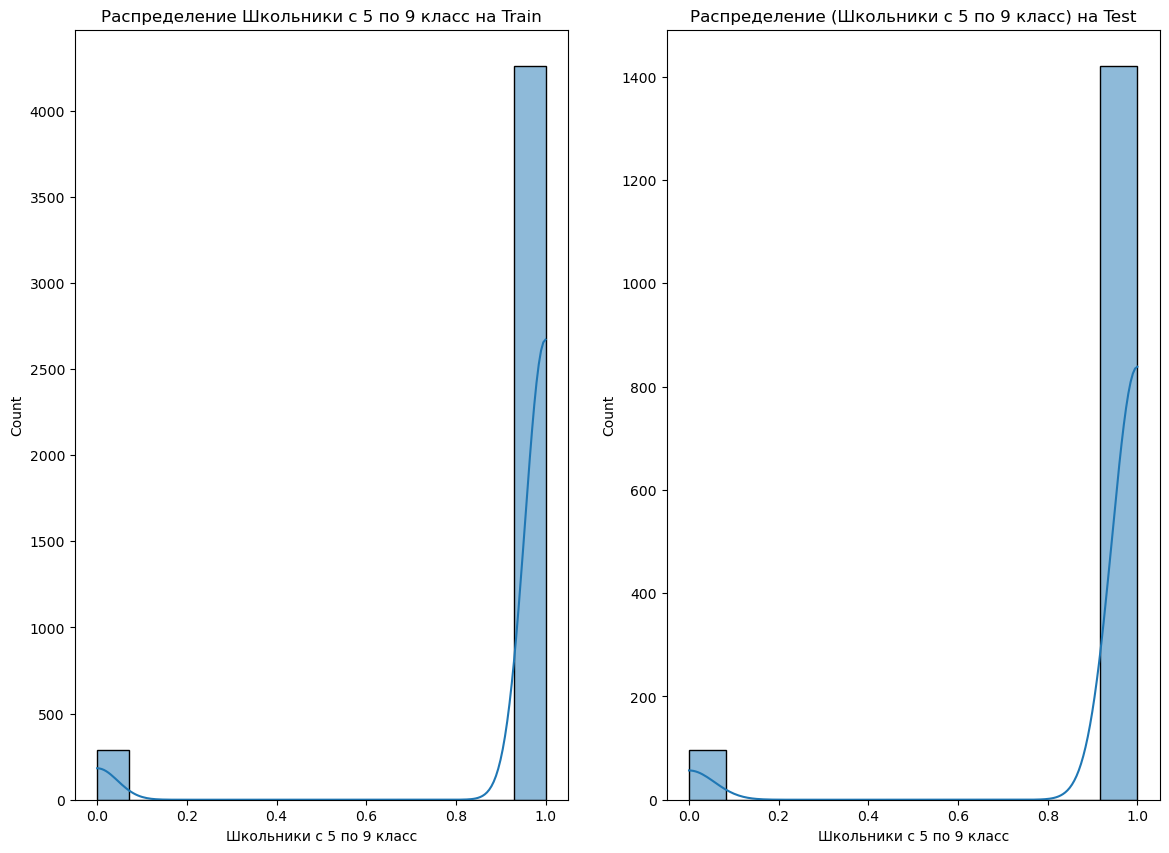

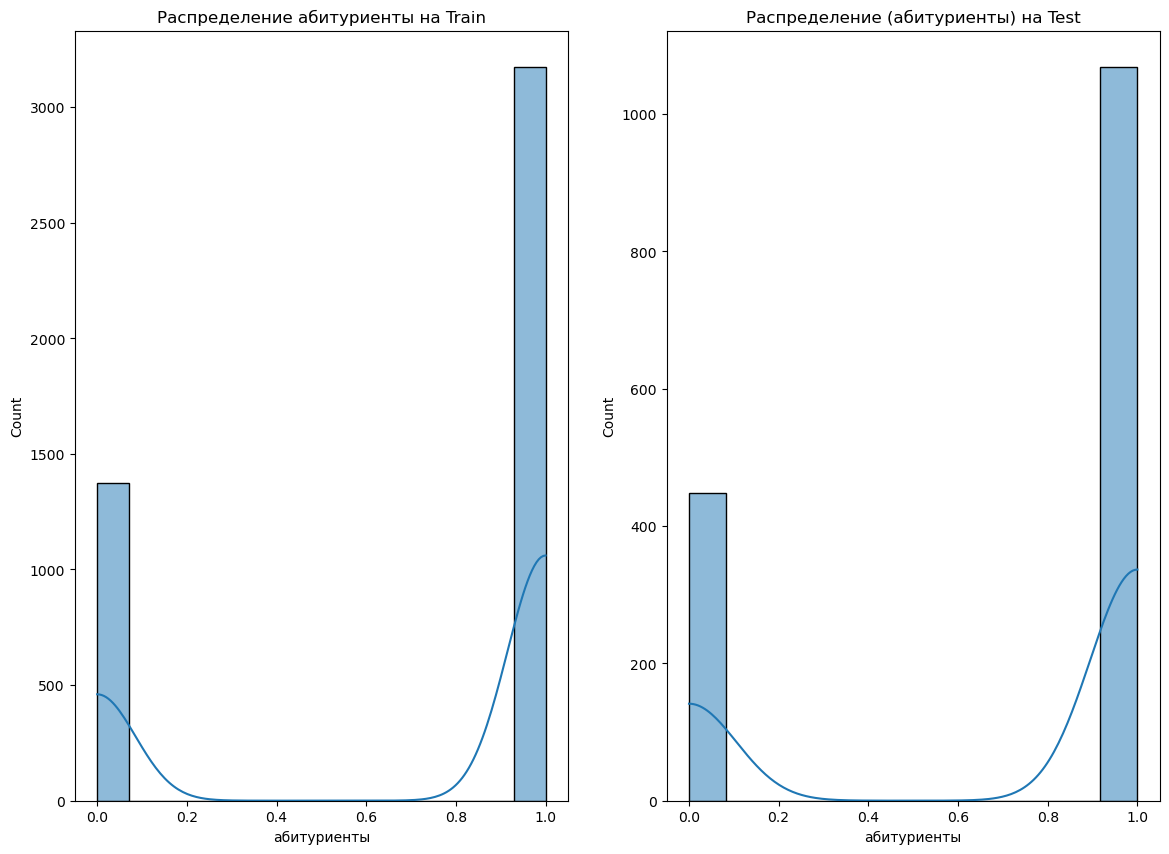

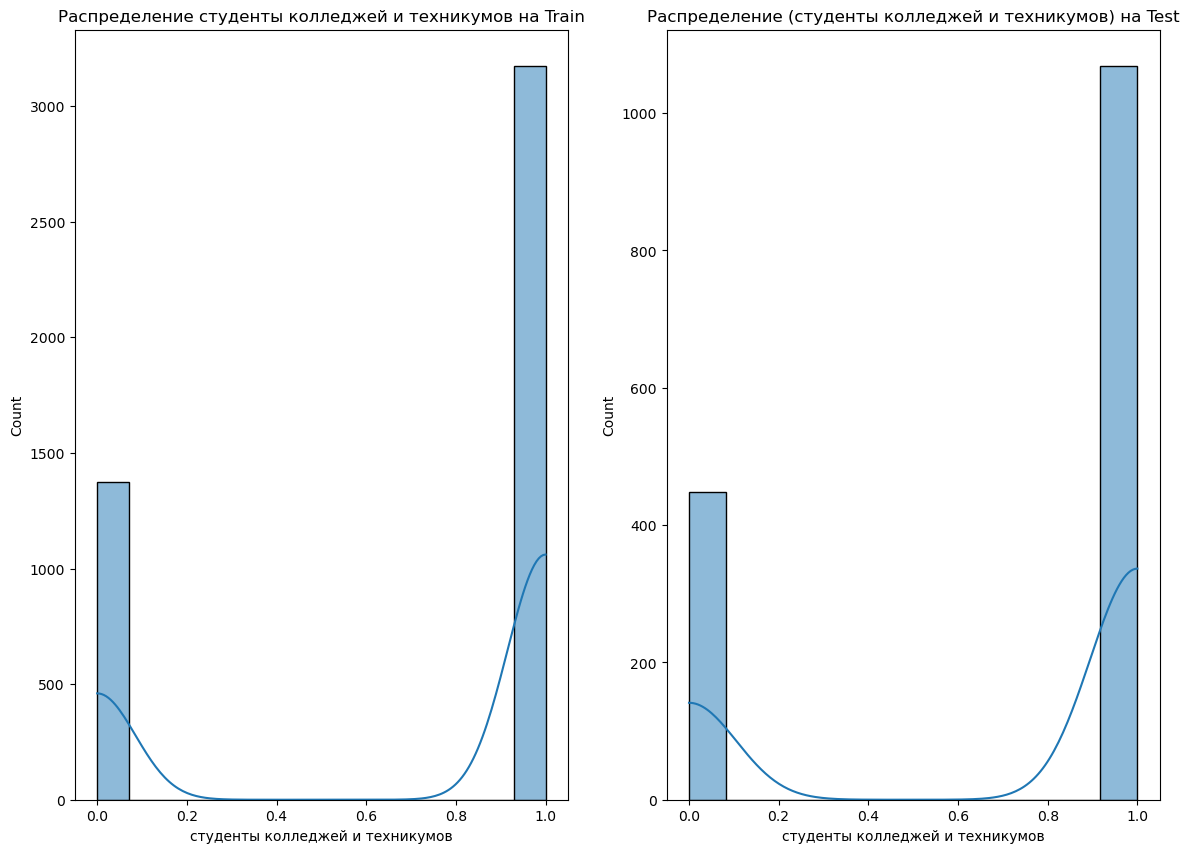

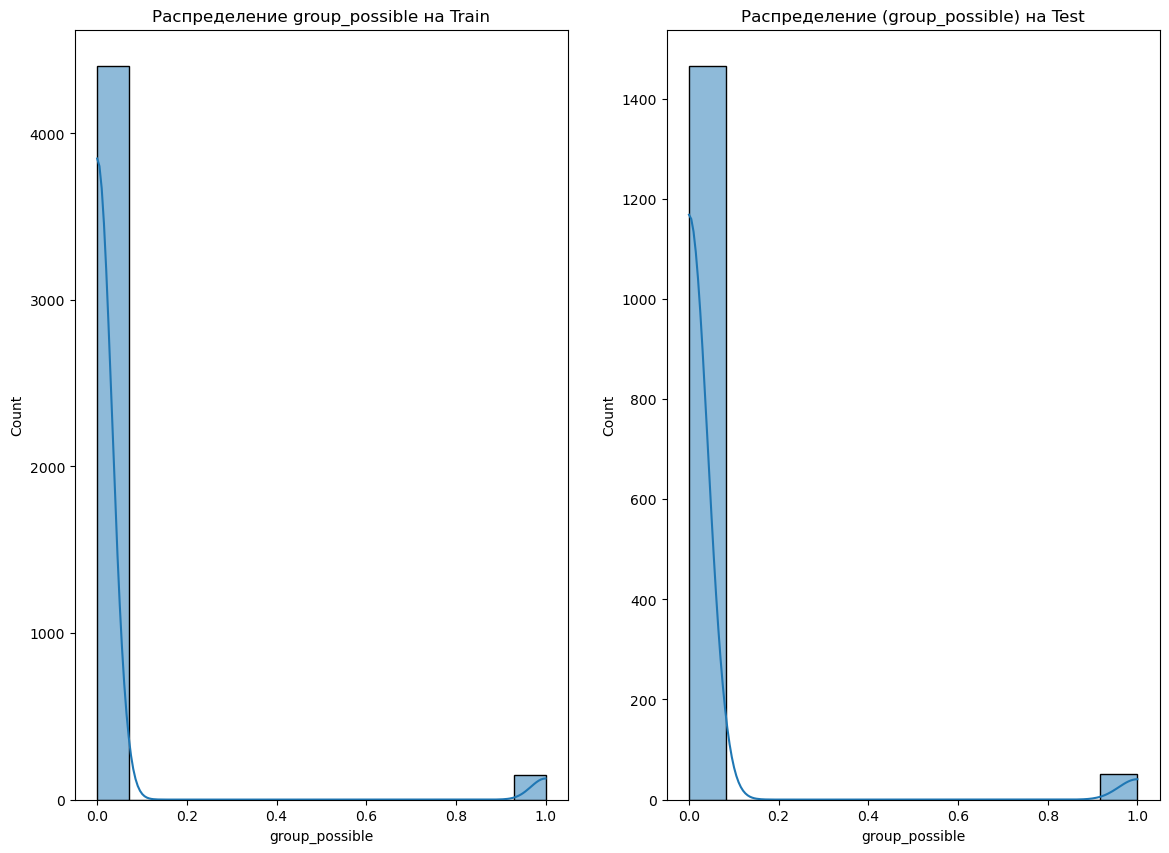

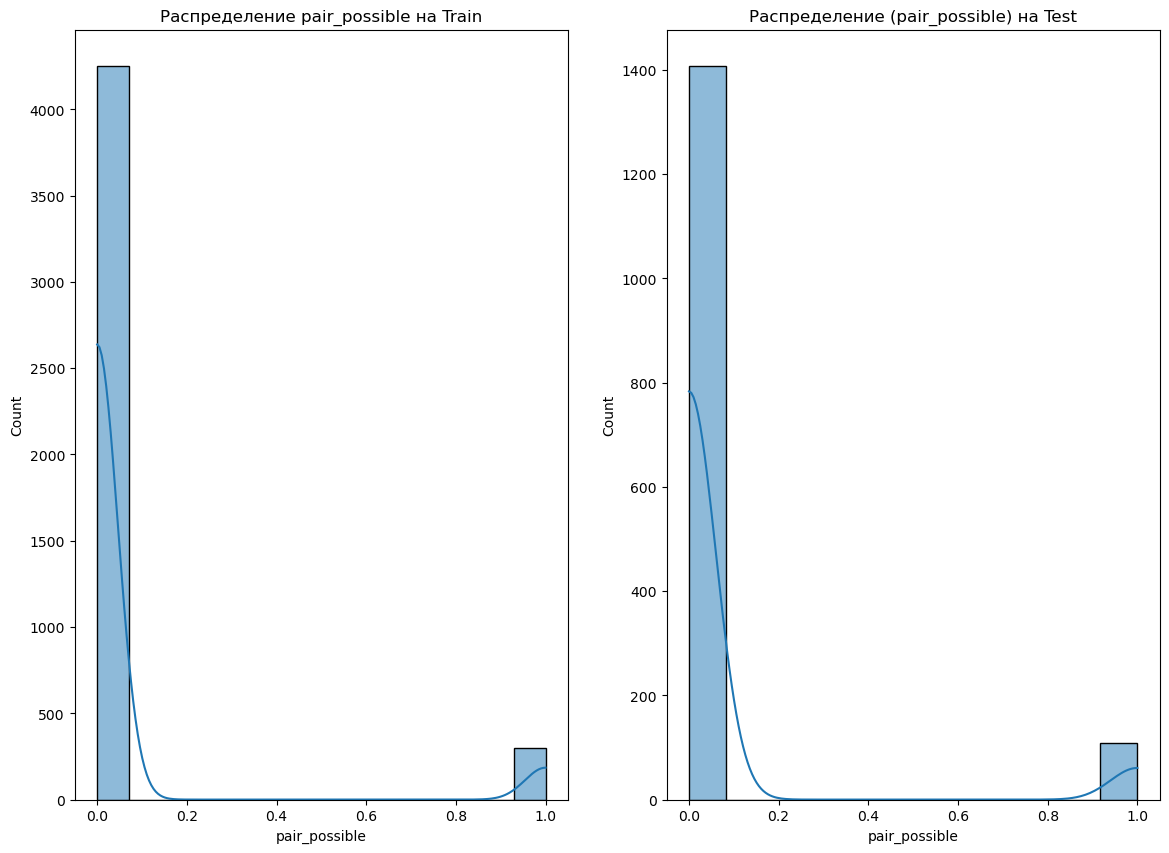

In [5759]:
for train_col, test_col in zip(train.drop(columns=["mean_price"]).columns, test.columns):
    plt.figure(figsize=(14, 10))
    
    plt.subplot(1, 2, 1)
    sns.histplot(train[train_col], kde=True)
    plt.title(f'Распределение {train_col} на Train')
    
    plt.subplot(1, 2, 2)
    sns.histplot(test[test_col], kde=True)
    plt.title(f'Распределение ({test_col}) на Test')
    
    plt.show()

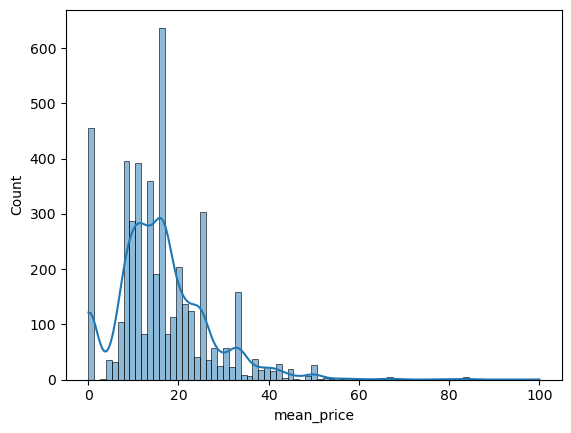

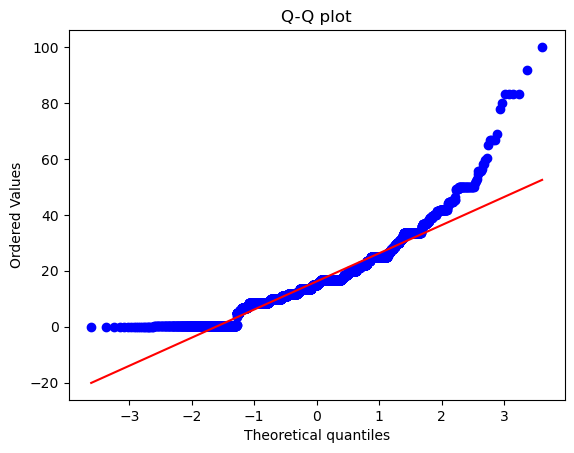

p-value теста Шапиро-Уилка: 0.0000


In [5760]:
sns.histplot(train["mean_price"], kde=True)
plt.show()

probplot(train["mean_price"], dist="norm", plot=plt)
plt.title("Q-Q plot")
plt.show()

_, p_value = shapiro(train["mean_price"])
print(f"p-value теста Шапиро-Уилка: {p_value:.4f}")

Левоассиметричное преобразование. Стоит задуматься об использовании нормализации, например, при помощи box-cox

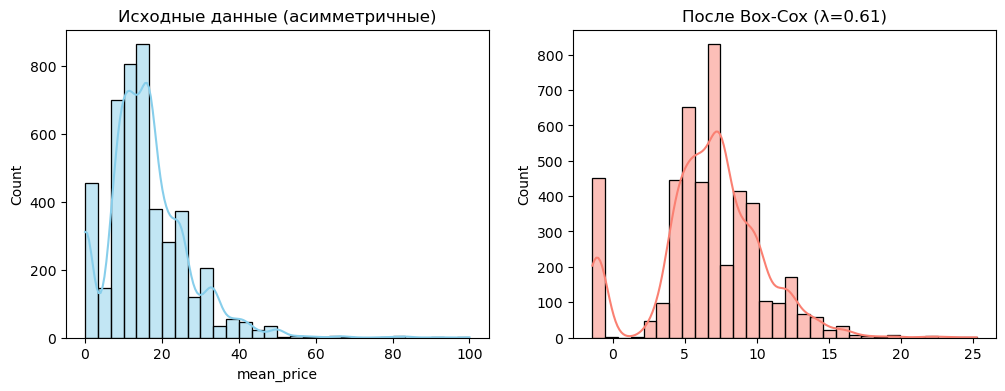

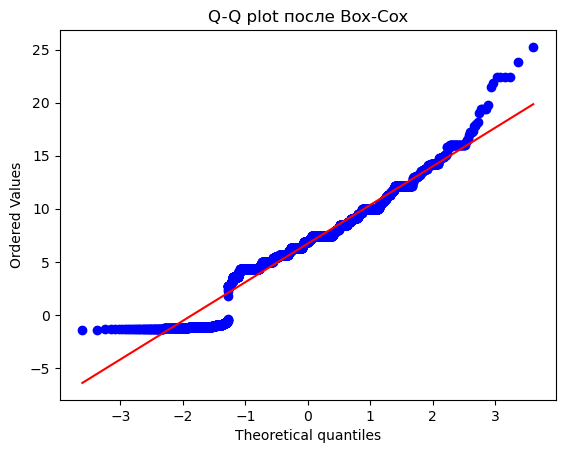

p-value теста Шапиро-Уилка: 0.0000


In [5761]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(train["mean_price"], bins=30, color='skyblue', edgecolor='black', kde=True)
plt.title('Исходные данные (асимметричные)')

transformed_data_box_cox, lambda_val = boxcox(train["mean_price"])

plt.subplot(1, 2, 2)
sns.histplot(transformed_data_box_cox, bins=30, color='salmon', edgecolor='black', kde=True)
plt.title(f'После Box-Cox (λ={lambda_val:.2f})')
plt.show()

probplot(transformed_data_box_cox, dist="norm", plot=plt)
plt.title("Q-Q plot после Box-Cox")
plt.show()

_, p_value = shapiro(transformed_data_box_cox)
print(f"p-value теста Шапиро-Уилка: {p_value:.4f}")

Визуально распределение стало ближе к нормальному, однако нулевое p-value смущает. 

Попробуем преобразования:

- с квадратным корнем
- robust

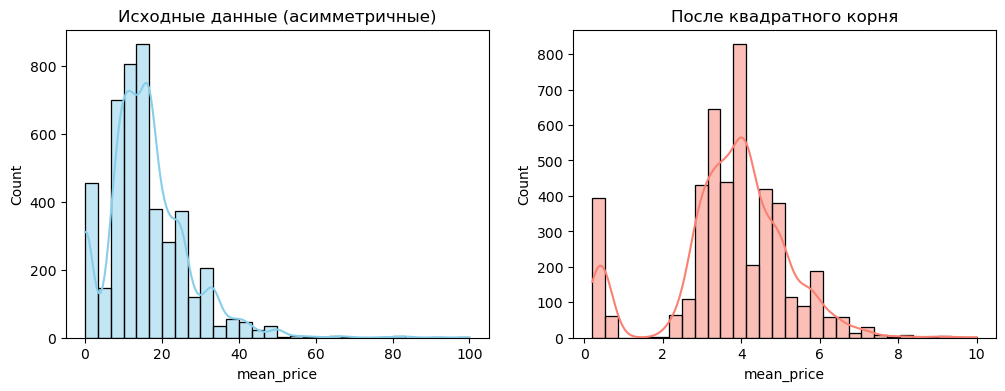

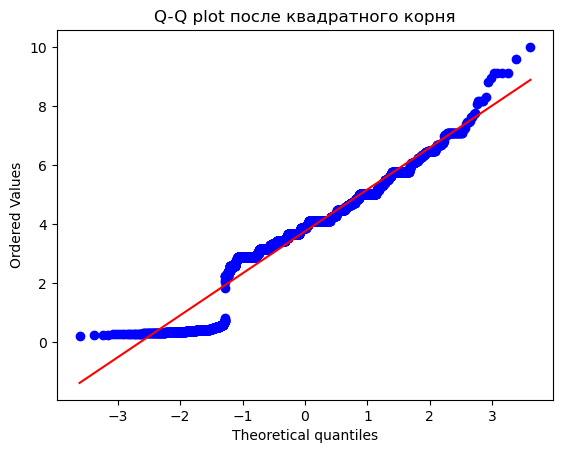

p-value теста Шапиро-Уилка: 0.0000


In [5762]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(train["mean_price"], bins=30, color='skyblue', edgecolor='black', kde=True)
plt.title('Исходные данные (асимметричные)')

sqrt_data = np.sqrt(train["mean_price"])

plt.subplot(1, 2, 2)
sns.histplot(sqrt_data, bins=30, color='salmon', edgecolor='black', kde=True)
plt.title('После квадратного корня')
plt.show()

probplot(sqrt_data, dist="norm", plot=plt)
plt.title("Q-Q plot после квадратного корня")
plt.show()

_, p_value = shapiro(sqrt_data)
print(f"p-value теста Шапиро-Уилка: {p_value:.4f}")

Характер распределения получился близок, к box-cox, но при детальном рассмотрении видно, что sqrt ближе к нормальному.

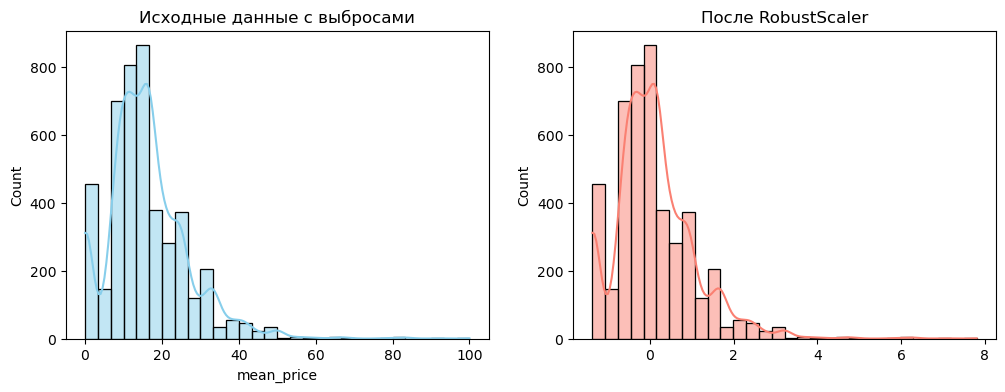

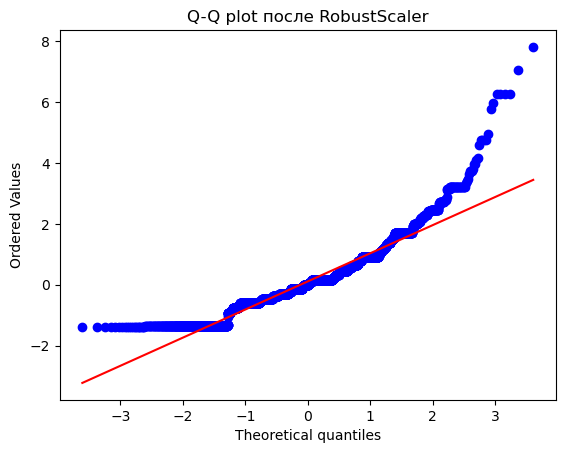

p-value теста Шапиро-Уилка: 0.0000


In [5763]:
from sklearn.preprocessing import RobustScaler

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(train["mean_price"], bins=30, color='skyblue', edgecolor='black', kde=True)
plt.title('Исходные данные с выбросами')

scaler = RobustScaler()
robust_data = scaler.fit_transform(train["mean_price"].values.reshape(-1, 1)).flatten()

plt.subplot(1, 2, 2)
sns.histplot(robust_data, bins=30, color='salmon', edgecolor='black', kde=True)
plt.title('После RobustScaler')
plt.show()

probplot(robust_data, dist="norm", plot=plt)
plt.title("Q-Q plot после RobustScaler")
plt.show()

_, p_value = shapiro(robust_data)
print(f"p-value теста Шапиро-Уилка: {p_value:.4f}")

Распределение не стало ближе к нормальному

Вывод: будем применять sqrt нормализацию

#### Encoding

1. Предмет -> Label
2. status -> Ordinal (можно попробовать, поскольку есть иерархия)/Label

In [5764]:
le = LabelEncoder()
train["предмет"] = le.fit_transform(train["предмет"])
test["предмет"] = le.transform(test["предмет"])

Для того, чтобы понять, как кодировать статус, проведём эксперимент:

посчитаем медианную заработную плату для репетитора каждого статуса, а затем проранжируем, на основе чего закодируем данные.

In [5765]:
train["status"].unique()

array([2, 4, 1, 0, 6, 9, 7, 3, 8, 5])

#### Корреляционный анализ

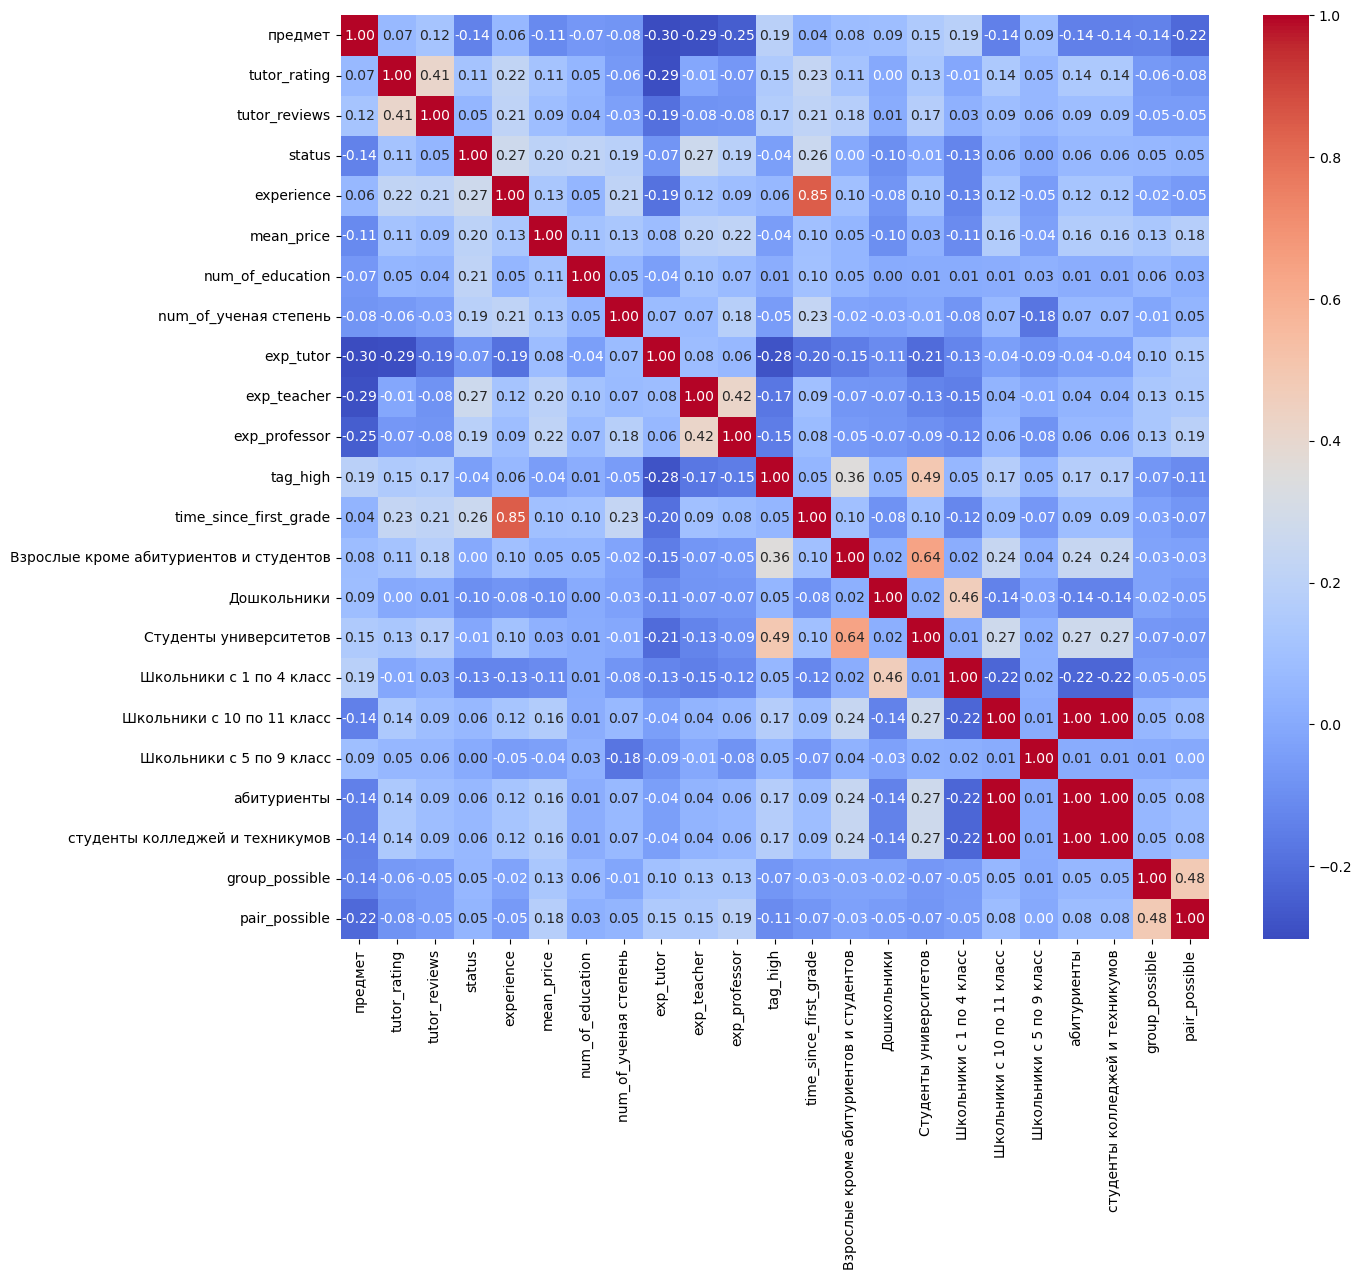

In [5766]:
corr_matrix = train.corr()
plt.figure(figsize=(14, 12))
sns.heatmap(
    data=corr_matrix,
    cmap='coolwarm',
    annot=True,
    fmt=".2f"
    )
plt.show()

Для первичной оценки воспользуемся поиском фичей, имеющих высокую корреляцию с таргетом

In [5767]:
high_corr_pairs = []
low_corr_target_features = []
important_features = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        pair = (corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            if corr_matrix.columns[i] == "mean_price":
                important_features.append(corr_matrix.columns[j])
                
            elif corr_matrix.columns[j] == "mean_price":
                important_features.append(corr_matrix.columns[i])
                
            else:
                high_corr_pairs.append(pair)
                
        elif abs(corr_matrix.iloc[i, j]) <= 0.1:
            if corr_matrix.columns[i] == "mean_price":
                low_corr_target_features.append(corr_matrix.columns[j])
                
            elif corr_matrix.columns[j] == "mean_price":
                low_corr_target_features.append(corr_matrix.columns[i])
            
        else:
            continue
        

print("\nПары признаков с корреляцией > 0.7:")
for pair in high_corr_pairs:
    print(f"{pair[0]} и {pair[1]}: {pair[2]:.2f}")
    
print("\nПары признаков с корреляцией <= 0.1 (с таргетом):")
for it in low_corr_target_features:
    print(it)
    
print("\nСписок важных фичей")
for it in important_features:
    print(it)


Пары признаков с корреляцией > 0.7:
experience и time_since_first_grade: 0.85
Школьники с 10 по 11 класс и абитуриенты: 1.00
Школьники с 10 по 11 класс и студенты колледжей и техникумов: 1.00
абитуриенты и студенты колледжей и техникумов: 1.00

Пары признаков с корреляцией <= 0.1 (с таргетом):
tutor_reviews
exp_tutor
tag_high
time_since_first_grade
Взрослые кроме абитуриентов и студентов
Дошкольники
Студенты университетов
Школьники с 5 по 9 класс

Список важных фичей


In [5768]:
print(len(train[train["абитуриенты"] == 1]))
print(len(train[train["студенты колледжей и техникумов"] == 1]))

3172
3172


Первично критических фичей с высокой предиктивной силой не обнаружено.

Кроме того, большинство фичей имеют слабую корреляцию с таргетом

Также обнаружены линейно зависимые пары и пара мультиколлинеарных признаков.

Линейно зависимые фичи сразу же подлежат чистке: удалим школьников 10 и 11 класса, а также студентов колледжей и техникумов, но сначала проведём статистические тесты и проверим важность признаков на базовой модели

<Axes: >

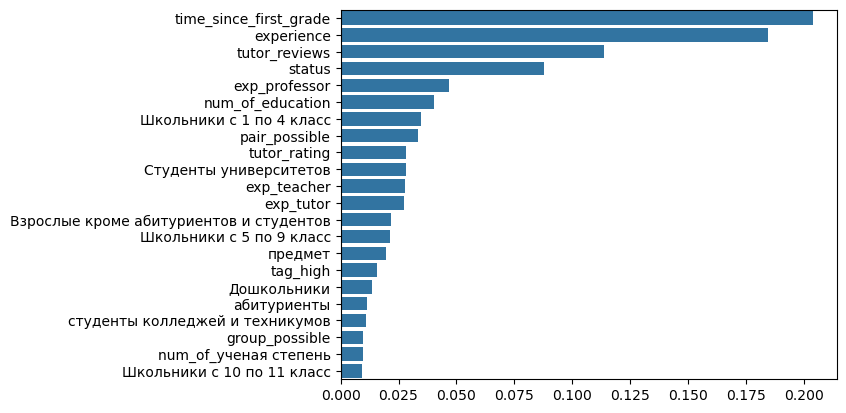

In [5769]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(train.drop(columns=["mean_price"]), train["mean_price"])
importance = pd.Series(model.feature_importances_, index=train.drop(columns=["mean_price"]).columns)
top_features = importance.sort_values(ascending=False).index
sns.barplot(importance.sort_values(ascending=False), orient="y")

Видно, что многие бинарные признаки на базовой модели не показывают высокой предиктивной силы. Это значит, не так важно, какой удалять

In [5770]:
chi_2_insignificant = []
mannwhitneyu_insignificant = []

cat_features = ["status"]
bin_features = [col for col in train.columns if train[col].nunique() == 2]
print(bin_features)

for col in train[cat_features].columns:
    contingency_table = pd.crosstab(train[col], train["mean_price"])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    if p_value > 0.05:
        chi_2_insignificant.append(col)
        
for col in train[bin_features].columns:
    group_0 = train[train[col] == 0]["mean_price"]
    group_1 = train[train[col] == 1]["mean_price"]

    stat, p_value = mannwhitneyu(group_0, group_1)
    if p_value > 0.05:
        mannwhitneyu_insignificant.append(col)
        
print(f"Связь данных признаков с таргетом статистически незначима: {chi_2_insignificant}")
print(f"Распределения одинаковы для: {mannwhitneyu_insignificant}")

['предмет', 'exp_tutor', 'exp_teacher', 'exp_professor', 'tag_high', 'Взрослые кроме абитуриентов и студентов', 'Дошкольники', 'Студенты университетов', 'Школьники с 1 по 4 класс', 'Школьники с 10 по 11 класс', 'Школьники с 5 по 9 класс', 'абитуриенты', 'студенты колледжей и техникумов', 'group_possible', 'pair_possible']
Связь данных признаков с таргетом статистически незначима: []
Распределения одинаковы для: ['Школьники с 5 по 9 класс']


Удалим признаки

In [5771]:
train = train.drop(columns=[
    'Школьники с 5 по 9 класс',
    "Школьники с 10 по 11 класс",
    "студенты колледжей и техникумов",
    "experience"
    ])
test = test.drop(columns=[
    'Школьники с 5 по 9 класс',
    "Школьники с 10 по 11 класс",
    "студенты колледжей и техникумов",
    "experience"
    ])

##### Проверим

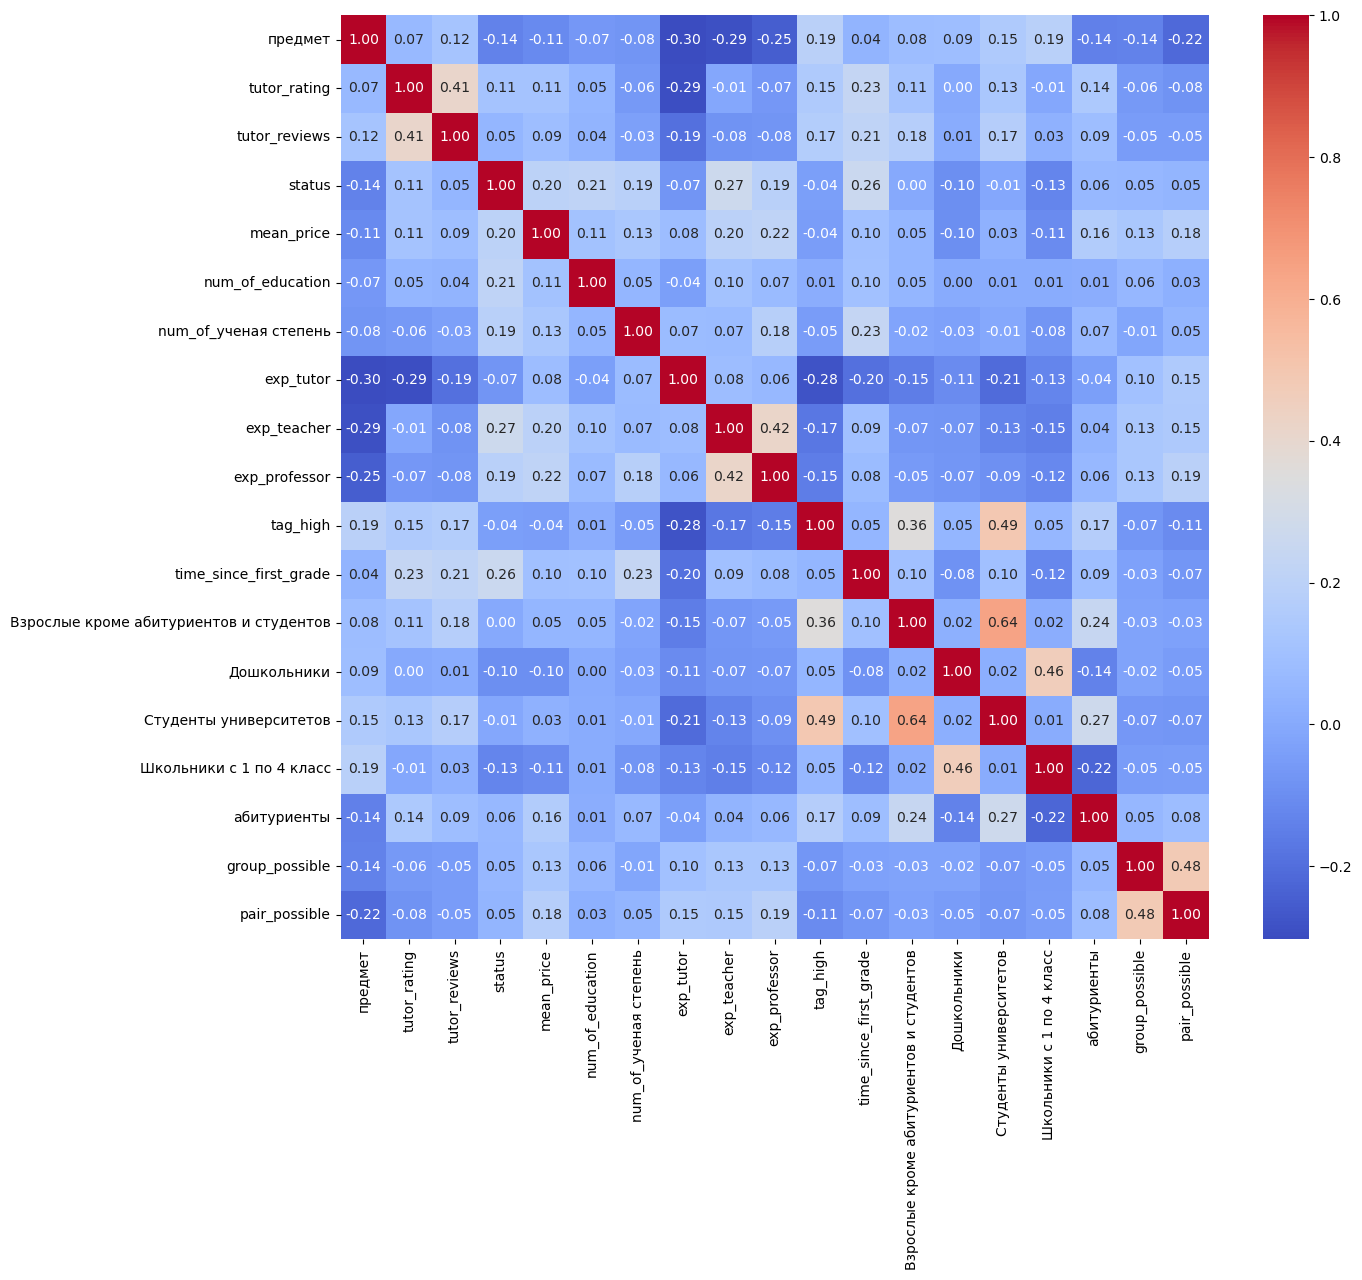

In [5772]:
corr_matrix = train.corr()
plt.figure(figsize=(14, 12))
sns.heatmap(
    data=corr_matrix,
    cmap='coolwarm',
    annot=True,
    fmt=".2f"
    )
plt.show()

In [5773]:
high_corr_pairs = []
low_corr_target_features = []
important_features = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        pair = (corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            if corr_matrix.columns[i] == "mean_price":
                important_features.append(corr_matrix.columns[j])
                
            elif corr_matrix.columns[j] == "mean_price":
                important_features.append(corr_matrix.columns[i])
                
            else:
                high_corr_pairs.append(pair)
                
        elif abs(corr_matrix.iloc[i, j]) <= 0.1:
            if corr_matrix.columns[i] == "mean_price":
                low_corr_target_features.append(corr_matrix.columns[j])
                
            elif corr_matrix.columns[j] == "mean_price":
                low_corr_target_features.append(corr_matrix.columns[i])
            
        else:
            continue
        

print("\nПары признаков с корреляцией > 0.7:")
for pair in high_corr_pairs:
    print(f"{pair[0]} и {pair[1]}: {pair[2]:.2f}")
    
print("\nПары признаков с корреляцией <= 0.1 (с таргетом):")
for it in low_corr_target_features:
    print(it)
    
print("\nСписок важных фичей")
for it in important_features:
    print(it)


Пары признаков с корреляцией > 0.7:

Пары признаков с корреляцией <= 0.1 (с таргетом):
tutor_reviews
exp_tutor
tag_high
time_since_first_grade
Взрослые кроме абитуриентов и студентов
Дошкольники
Студенты университетов

Список важных фичей


<Axes: >

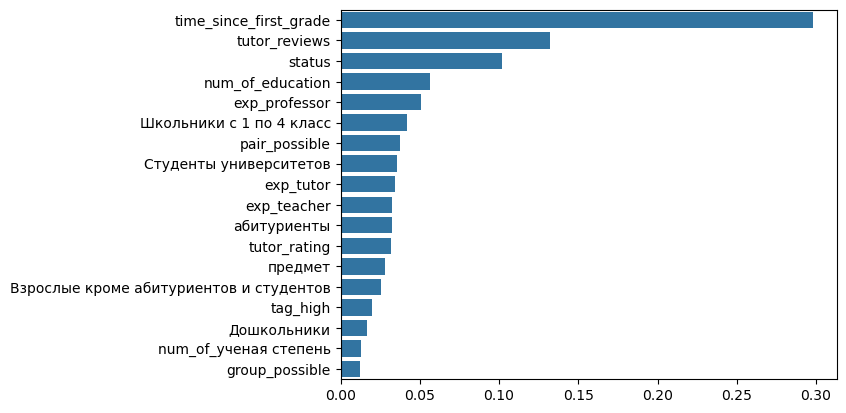

In [5774]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(train.drop(columns=["mean_price"]), train["mean_price"])
importance = pd.Series(model.feature_importances_, index=train.drop(columns=["mean_price"]).columns)
top_features = importance.sort_values(ascending=False).index
sns.barplot(importance.sort_values(ascending=False), orient="y")

### Анализ выбросов

In [5775]:
traget = "mean_price"

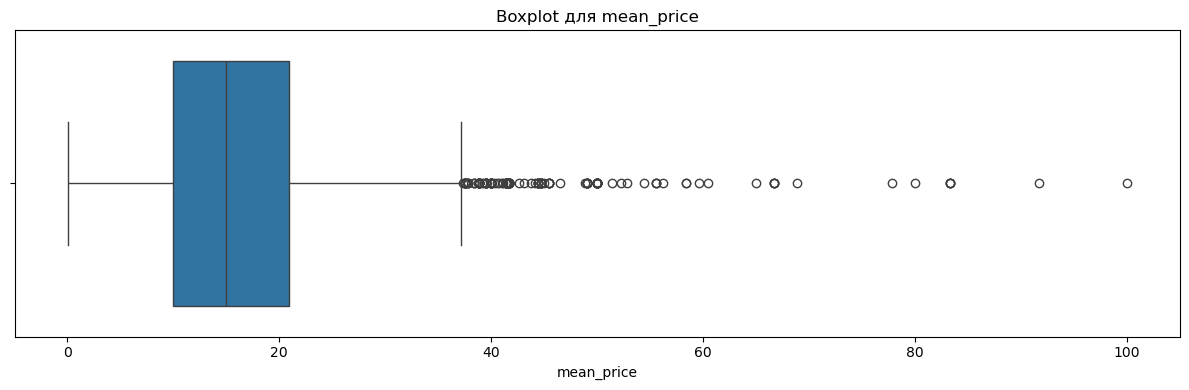

In [5776]:
plt.figure(figsize=(12, 4))

sns.boxplot(x=train[target])

plt.title(f'Boxplot для {target}')
plt.tight_layout()
plt.show()

Выбросы по правилу 3 сигм: (59, 19)


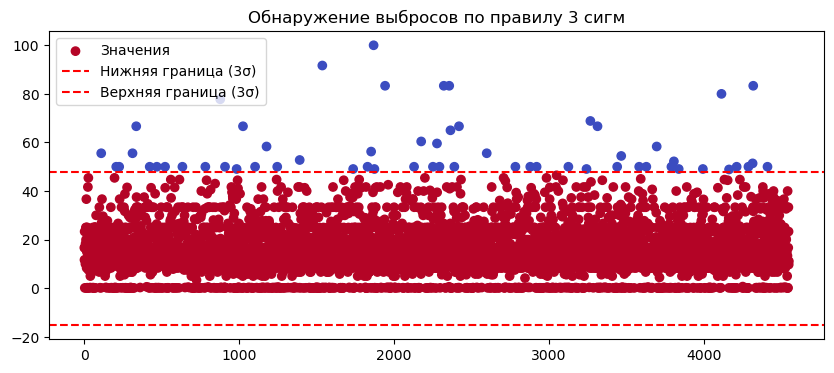

In [5777]:
mean = train[target].mean()
std = train[target].std()
lower_bound = mean - 3 * std
upper_bound = mean + 3 * std

outliers = train[(train[target] < lower_bound) | (train[target] > upper_bound)]

print("Выбросы по правилу 3 сигм:", outliers.shape)

train['is_outlier_3σ'] = (train[target] < lower_bound) | (train[target] > upper_bound)

plt.figure(figsize=(10, 4))
plt.scatter(train.index, train[target], c=~train['is_outlier_3σ'], cmap='coolwarm', label='Значения')
plt.axhline(y=lower_bound, color='r', linestyle='--', label='Нижняя граница (3σ)')
plt.axhline(y=upper_bound, color='r', linestyle='--', label='Верхняя граница (3σ)')
plt.legend()
plt.title('Обнаружение выбросов по правилу 3 сигм')
plt.show()

Выбросы по правилу межквартильного размаха: (174, 21)


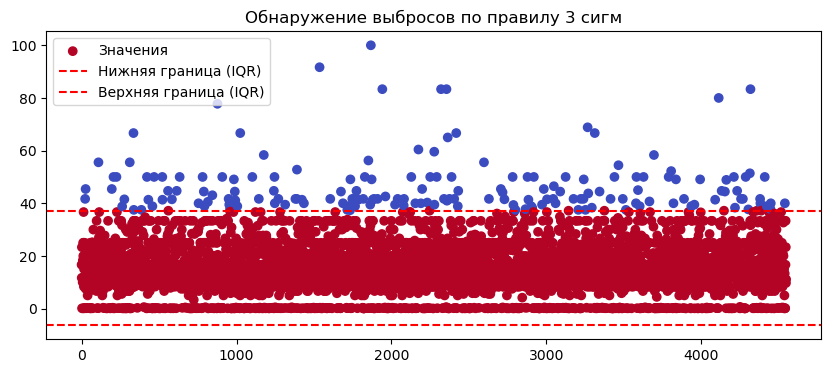

In [5778]:
Q1 = train[target].quantile(0.25)
Q3 = train[target].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
train["is_outlier_IQR"] = (train[target] < lower_bound) | (train[target] > upper_bound)
train[(train[target] < lower_bound) | (train[target] > upper_bound)]

print("Выбросы по правилу межквартильного размаха:", train[(train[target] < lower_bound) | (train[target] > upper_bound)].shape)

plt.figure(figsize=(10, 4))
plt.scatter(train.index, train[target], c=~train['is_outlier_IQR'], cmap='coolwarm', label='Значения')
plt.axhline(y=lower_bound, color='r', linestyle='--', label='Нижняя граница (IQR)')
plt.axhline(y=upper_bound, color='r', linestyle='--', label='Верхняя граница (IQR)')
plt.legend()
plt.title('Обнаружение выбросов по правилу 3 сигм')
plt.show()

In [5779]:
train = train.drop(columns=['is_outlier_IQR', 'is_outlier_3σ'])

IQR слишком агрессивен. В рамках предметной области мы не хотим отрезать важные результаты
3 сигма, как видно, тоже отрезает не только аномальные значения. 

На наш взгляд, лучше использовать модели, устойчивые к выбросам. 

#### Скейлинг фичей

In [5780]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4548 entries, 0 to 4547
Data columns (total 19 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   предмет                                  4548 non-null   int64  
 1   tutor_rating                             4548 non-null   float64
 2   tutor_reviews                            4548 non-null   int64  
 3   status                                   4548 non-null   int64  
 4   mean_price                               4548 non-null   float64
 5   num_of_education                         4548 non-null   int64  
 6   num_of_ученая степень                    4548 non-null   int64  
 7   exp_tutor                                4548 non-null   Int16  
 8   exp_teacher                              4548 non-null   Int16  
 9   exp_professor                            4548 non-null   Int16  
 10  tag_high                                 4548 no

In [5781]:
train["tutor_rating"] = train["tutor_rating"].astype("Int16")

In [5782]:
train["num_of_education"].unique()

array([1, 2, 3, 4, 5, 6])

In [5783]:
train["num_of_ученая степень"].unique()

array([0, 1, 2])

In [5784]:
train["status"].unique()

array([2, 4, 1, 0, 6, 9, 7, 3, 8, 5])

In [5785]:
# train["mean_price"] = np.sqrt(train["mean_price"])

## Обучение

Для регрессии будем использовать:
- RandomForrest
- XGBoostRegressor
- SVR

In [5786]:
y_train = train["mean_price"]
X_train = train.drop(columns=["mean_price"])

In [5787]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4548 entries, 0 to 4547
Data columns (total 18 columns):
 #   Column                                   Non-Null Count  Dtype
---  ------                                   --------------  -----
 0   предмет                                  4548 non-null   int64
 1   tutor_rating                             4548 non-null   Int16
 2   tutor_reviews                            4548 non-null   int64
 3   status                                   4548 non-null   int64
 4   num_of_education                         4548 non-null   int64
 5   num_of_ученая степень                    4548 non-null   int64
 6   exp_tutor                                4548 non-null   Int16
 7   exp_teacher                              4548 non-null   Int16
 8   exp_professor                            4548 non-null   Int16
 9   tag_high                                 4548 non-null   Int16
 10  time_since_first_grade                   4548 non-null   Int16
 11  Взро

In [ ]:
models = {
    "RF": RandomForestRegressor(random_state=42),
    "XGB": XGBRegressor(random_state=42),
    "XGBFR": XGBRFRegressor(random_state=42),
    "SVR": SVR(kernel="linear", C=1.0, epsilon=0.1)
}

metrics = {
    'R2': r2_score,
    'MSE': mean_squared_error,
    'RMSE': lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    'MAE': mean_absolute_error,
    'MAPE': mean_absolute_percentage_error,
    'MSLE': mean_squared_log_error,
    'MedAE': median_absolute_error,
    'SMAPE': lambda y_true, y_pred: np.mean(np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))) * 100,
    'Explained Variance': explained_variance_score,
    'MaxError': max_error,
}

In [5789]:
X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

In [5790]:
X_train_train.shape

(3638, 18)

In [5791]:
y_train_train.shape

(3638,)

In [5792]:
results = []

for name, model in models.items():
    cv_scores = cross_val_score(model, X_train_train, y_train_train, 
                               cv=10, scoring='r2', n_jobs=-1)
    
    model.fit(X_train_train, y_train_train)
    y_pred = model.predict(X_train_test)
    
    model_metrics = {metric_name: metric_func(y_train_test, y_pred) 
                     for metric_name, metric_func in metrics.items()}
    
    results.append({
        'model': name,
        'cv_mean_r2': np.mean(cv_scores),
        'cv_std_r2': np.std(cv_scores),
        **model_metrics
    })

results_df = pd.DataFrame(results)
print(results_df)

   model  cv_mean_r2  cv_std_r2        R2       RMSE       MAE      MAPE  \
0     RF    0.130971   0.076514  0.124779  10.161869  6.628963  9.465362   
1    XGB    0.151934   0.062721  0.101571  10.295719  6.659638  9.187153   
2  XGBFR    0.191858   0.047149  0.180433   9.833473  6.511242  9.284673   
3    SVR    0.128189   0.056942  0.137556  10.087422  6.739452  9.196565   

       MSLE     MedAE      SMAPE  Explained Variance   MaxError  
0  0.806991  4.695641  23.408812            0.125147  89.231913  
1  0.818216  4.342951  23.289425            0.102191  89.180397  
2  0.780574  4.362625  22.690105            0.181232  85.640474  
3  0.783642  4.382915  23.278997            0.143056  86.338991  


В целом R2 неудовлетворительный. Попытаемся решить при помощи оптимизации

### Оптимизации

In [5793]:
N_TRIALS_RF = 100
CV_FOLDS_RF = 10

N_TRIALS_XGB = 100
CV_FOLDS_XGB = 10

N_TRIALS_SVR = 30
CV_FOLDS_SVR = 5

#### RF

In [5794]:
def optimize_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }
    
    model = RandomForestRegressor(
        **params,
        random_state=42,
        n_jobs=-1
    )
    
    r2_scores = cross_val_score(
        model, X_train_train, y_train_train, 
        cv=CV_FOLDS_RF, scoring='r2', n_jobs=-1
    )
    
    return np.mean(r2_scores)

In [5795]:
study_rf = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42)
)
study_rf.optimize(optimize_rf, n_trials=N_TRIALS_RF)

[I 2025-06-14 02:31:28,663] A new study created in memory with name: no-name-09637148-d158-4eec-a217-0a3e2975411d


[I 2025-06-14 02:31:30,301] Trial 0 finished with value: 0.2210069049060507 and parameters: {'n_estimators': 437, 'max_depth': 48, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.2210069049060507.
[I 2025-06-14 02:31:32,282] Trial 1 finished with value: 0.2043285472821096 and parameters: {'n_estimators': 641, 'max_depth': 37, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.2210069049060507.
[I 2025-06-14 02:31:33,679] Trial 2 finished with value: 0.22982448475265813 and parameters: {'n_estimators': 374, 'max_depth': 29, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 2 with value: 0.22982448475265813.
[I 2025-06-14 02:31:35,208] Trial 3 finished with value: 0.2077947376935409 and parameters: {'n_estimators': 510, 'max_depth': 41, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max

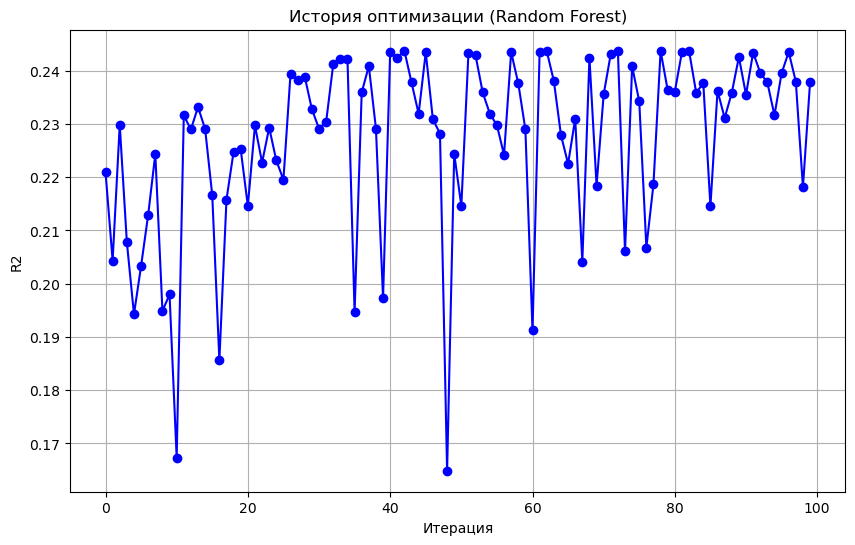

In [5796]:
import matplotlib.pyplot as plt

trials = study_rf.trials
steps = [trial.number for trial in trials]
values = [trial.value for trial in trials]

plt.figure(figsize=(10, 6))
plt.plot(steps, values, marker='o', linestyle='-', color='b')
plt.xlabel('Итерация')
plt.ylabel('R2')
plt.title('История оптимизации (Random Forest)')
plt.grid(True)
plt.show()

Лучшие параметры для Random Forest:
{'n_estimators': 658, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': False}
Лучший R2: 0.2438


/var/folders/57/kcjkgrt57m13wnf0__qcxmbm0000gn/T/ipykernel_7961/3609037799.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance_values, y=params, palette="viridis")


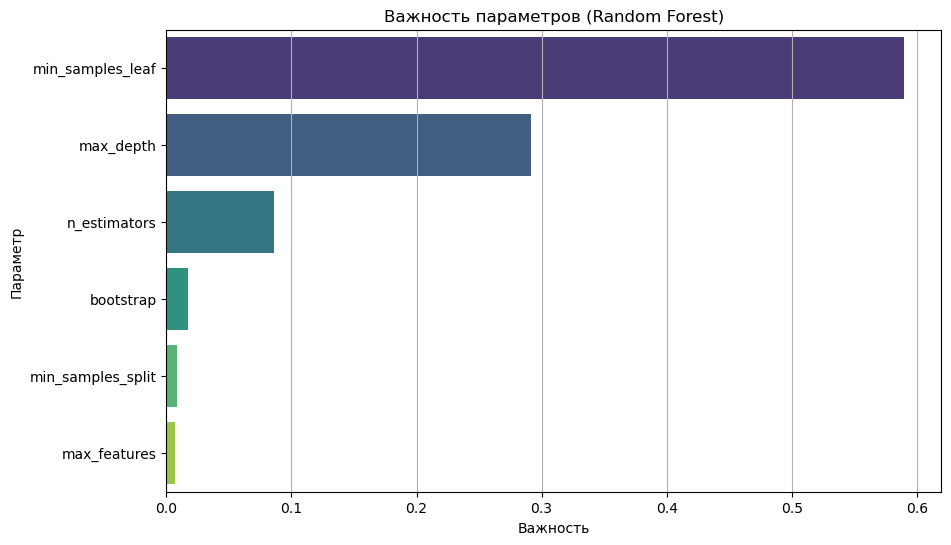

In [5797]:
print(f"Лучшие параметры для Random Forest:")
print(study_rf.best_params)
print(f"Лучший R2: {study_rf.best_value:.4f}")

importances = optuna.importance.get_param_importances(study_rf)

params = list(importances.keys())
importance_values = list(importances.values())

plt.figure(figsize=(10, 6))
sns.barplot(x=importance_values, y=params, palette="viridis")
plt.xlabel('Важность')
plt.ylabel('Параметр')
plt.title('Важность параметров (Random Forest)')
plt.grid(axis='x')
plt.show()

In [5798]:
best_rf_model = RandomForestRegressor(
    **study_rf.best_params,
    random_state=42,
    n_jobs=-1
)
best_rf_model.fit(X_train_train, y_train_train)

RandomForestRegressor(bootstrap=False, max_depth=14, max_features='log2',
                      min_samples_leaf=3, n_estimators=658, n_jobs=-1,
                      random_state=42)

In [5799]:
y_pred_best_rf = best_rf_model.predict(X_train_test)

final_metrics_rf = {metric_name: metric_func(y_train_test, y_pred_best_rf) 
                 for metric_name, metric_func in metrics.items()}

print("\nFinal Metrics on Test Set:")
for metric, value in final_metrics_rf.items():
    print(f"{metric}: {value:.4f}")


Final Metrics on Test Set:
R2: 0.2102
RMSE: 9.6535
MAE: 6.1405
MAPE: 9.1010
MSLE: 0.7641
MedAE: 3.8174
SMAPE: 21.6972
Explained Variance: 0.2115
MaxError: 87.7130


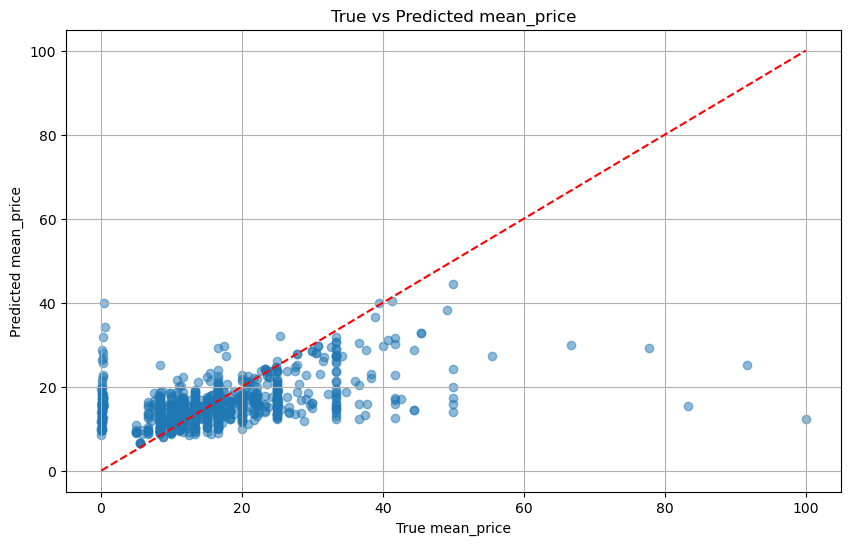

In [5800]:
plt.figure(figsize=(10, 6))
plt.scatter(y_train_test, y_pred_best_rf, alpha=0.5)
plt.plot([min(y_train_test), max(y_train_test)], 
         [min(y_train_test), max(y_train_test)], 'r--')
plt.xlabel('True mean_price')
plt.ylabel('Predicted mean_price')
plt.title('True vs Predicted mean_price')
plt.grid(True)
plt.show()

#### XGB

In [ ]:
def optimize_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10)
    }
    
    model = XGBRegressor(
        **params,
        random_state=42,
        tree_method='exact',
    )
    
    r2_scores = cross_val_score(
        model, X_train_train, y_train_train, 
        cv=CV_FOLDS_XGB, scoring='r2', n_jobs=-1
    )
    
    return np.mean(r2_scores)


In [5806]:
study_xgb = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42)
)
study_xgb.optimize(optimize_xgb, n_trials=N_TRIALS_XGB)

[I 2025-06-14 02:38:24,715] A new study created in memory with name: no-name-8475be54-a760-46ec-b9d2-f25f71ffdd3c
[I 2025-06-14 02:38:28,247] Trial 0 finished with value: 0.1256070413222262 and parameters: {'n_estimators': 437, 'max_depth': 12, 'learning_rate': 0.06504856968981275, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'reg_alpha': 0.5808361216819946, 'reg_lambda': 8.661761457749352}. Best is trial 0 with value: 0.1256070413222262.
[I 2025-06-14 02:38:33,462] Trial 1 finished with value: 0.1710155045346585 and parameters: {'n_estimators': 641, 'max_depth': 10, 'learning_rate': 0.001124579825911934, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'gamma': 1.0616955533913808, 'reg_alpha': 1.8182496720710062, 'reg_lambda': 1.8340450985343382}. Best is trial 1 with value: 0.1710155045346585.
[I 2025-06-14 02:38:35,762] Trial 2 finished with value: 0.23489158211965194 and parameters: {'n_estimators': 37

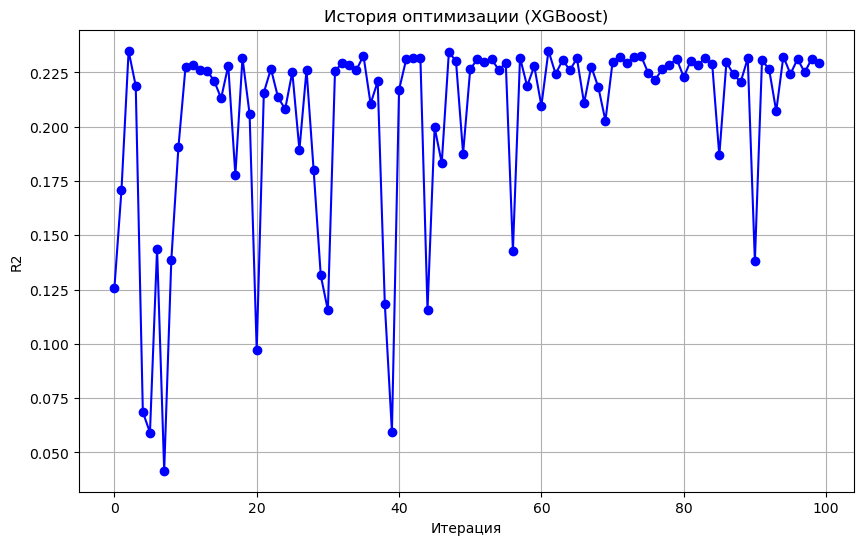

In [5807]:
import matplotlib.pyplot as plt

trials = study_xgb.trials
steps = [trial.number for trial in trials]
values = [trial.value for trial in trials]

plt.figure(figsize=(10, 6))
plt.plot(steps, values, marker='o', linestyle='-', color='b')
plt.xlabel('Итерация')
plt.ylabel('R2')
plt.title('История оптимизации (XGBoost)')
plt.grid(True)
plt.show()

Лучшие параметры для XGBoost:
{'n_estimators': 459, 'max_depth': 8, 'learning_rate': 0.010825778373604718, 'subsample': 0.6795846449736033, 'colsample_bytree': 0.7552512538327913, 'gamma': 0.6818161738318281, 'reg_alpha': 2.3025650510514746, 'reg_lambda': 2.802777540497876}
Лучший R2: 0.2350


/var/folders/57/kcjkgrt57m13wnf0__qcxmbm0000gn/T/ipykernel_7961/4161863099.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance_values, y=params, palette="viridis")


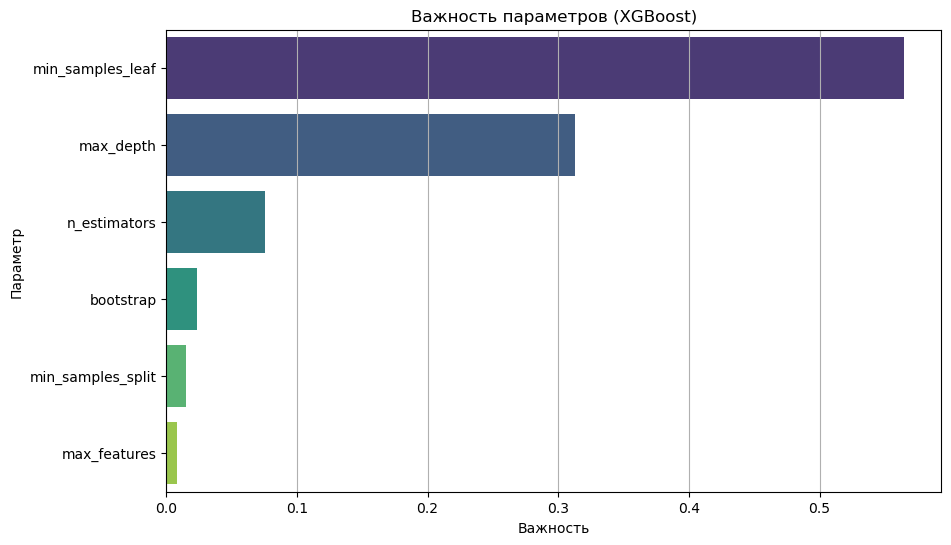

In [5808]:
print(f"Лучшие параметры для XGBoost:")
print(study_xgb.best_params)
print(f"Лучший R2: {study_xgb.best_value:.4f}")

importances = optuna.importance.get_param_importances(study_rf)

params = list(importances.keys())
importance_values = list(importances.values())

plt.figure(figsize=(10, 6))
sns.barplot(x=importance_values, y=params, palette="viridis")
plt.xlabel('Важность')
plt.ylabel('Параметр')
plt.title('Важность параметров (XGBoost)')
plt.grid(axis='x')
plt.show()

In [5810]:
best_xgb_model = XGBRegressor(
    **study_xgb.best_params,
    random_state=42,
    tree_method="exact",
    n_jobs=-1
)
best_xgb_model.fit(X_train_train, y_train_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7552512538327913, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=0.6818161738318281, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.010825778373604718,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=459, n_jobs=-1,
             num_parallel_tree=None, ...)

In [5811]:
y_pred_best_xgb = best_xgb_model.predict(X_train_test)

final_metrics_xgb = {metric_name: metric_func(y_train_test, y_pred_best_xgb) 
                 for metric_name, metric_func in metrics.items()}

print("\nFinal Metrics on Test Set:")
for metric, value in final_metrics_xgb.items():
    print(f"{metric}: {value:.4f}")


Final Metrics on Test Set:
R2: 0.1985
RMSE: 9.7243
MAE: 6.2315
MAPE: 9.1334
MSLE: 0.7693
MedAE: 3.8940
SMAPE: 21.9429
Explained Variance: 0.1994
MaxError: 87.1501


#### XGBRF

In [ ]:
def optimize_xgbrf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'tree_method': 'hist',
        'random_state': 42,
        'verbosity': 0,
    }

    model = XGBRFRegressor(**params)

    r2_scores = cross_val_score(
        model, X_train_train, y_train_train,
        cv=CV_FOLDS_XGB,
        scoring='r2',
        n_jobs=-1
    )
    return np.mean(r2_scores)

In [5834]:
study_xgbrf = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42)
)
study_xgbrf.optimize(optimize_xgbrf, n_trials=N_TRIALS_XGB)

[I 2025-06-14 03:12:00,741] A new study created in memory with name: no-name-d80841b7-8a7d-492c-a26b-1dad3d18ef74
[I 2025-06-14 03:12:05,256] Trial 0 finished with value: 0.22220237199526535 and parameters: {'n_estimators': 437, 'max_depth': 12, 'subsample': 0.8659969709057025, 'colsample_bynode': 0.7993292420985183, 'gamma': 0.7800932022121826, 'reg_alpha': 1.5599452033620265, 'reg_lambda': 0.5808361216819946}. Best is trial 0 with value: 0.22220237199526535.
[I 2025-06-14 03:12:06,077] Trial 1 finished with value: 0.21721598907203118 and parameters: {'n_estimators': 880, 'max_depth': 9, 'subsample': 0.8540362888980227, 'colsample_bynode': 0.5102922471479012, 'gamma': 4.8495492608099715, 'reg_alpha': 8.324426408004218, 'reg_lambda': 2.1233911067827616}. Best is trial 0 with value: 0.22220237199526535.
[I 2025-06-14 03:12:06,219] Trial 2 finished with value: 0.14276087211666916 and parameters: {'n_estimators': 263, 'max_depth': 4, 'subsample': 0.6521211214797689, 'colsample_bynode': 0.

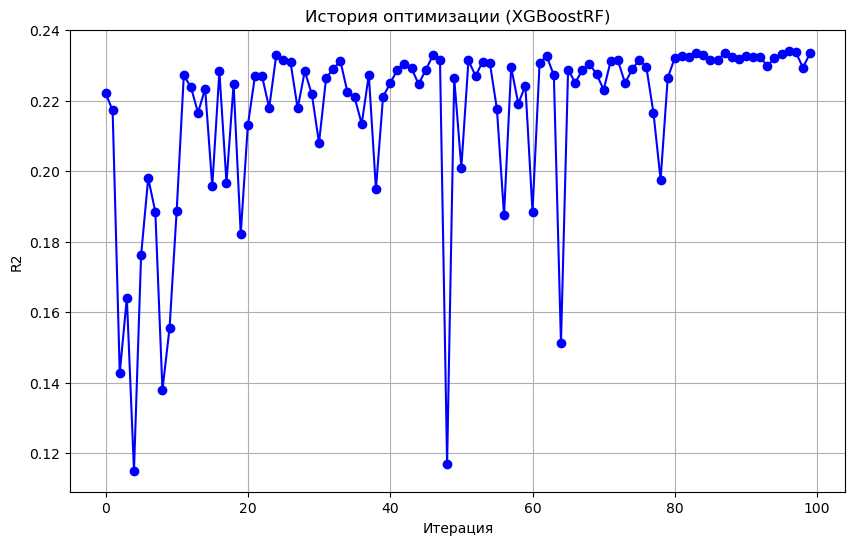

In [5835]:
import matplotlib.pyplot as plt

trials = study_xgbrf.trials
steps = [trial.number for trial in trials]
values = [trial.value for trial in trials]

plt.figure(figsize=(10, 6))
plt.plot(steps, values, marker='o', linestyle='-', color='b')
plt.xlabel('Итерация')
plt.ylabel('R2')
plt.title('История оптимизации (XGBoostRF)')
plt.grid(True)
plt.show()

Лучшие параметры для XGBoostRF:
{'n_estimators': 717, 'max_depth': 11, 'subsample': 0.8753305638932896, 'colsample_bynode': 0.5123502826413412, 'gamma': 2.530146019134998, 'reg_alpha': 1.0601403561666887, 'reg_lambda': 0.6829664686861857}
Лучший R2: 0.2341


/var/folders/57/kcjkgrt57m13wnf0__qcxmbm0000gn/T/ipykernel_7961/2266525910.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance_values, y=params, palette="viridis")


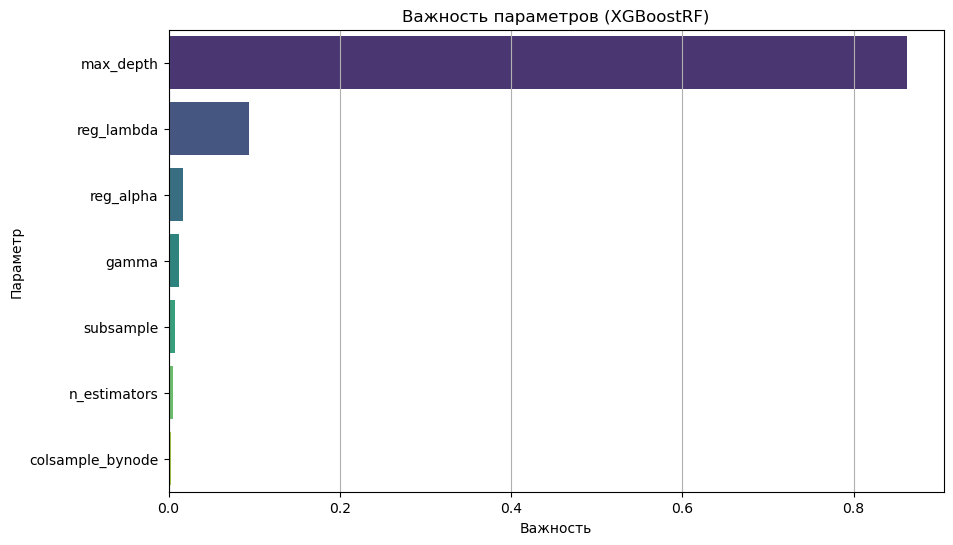

In [5837]:
print(f"Лучшие параметры для XGBoostRF:")
print(study_xgbrf.best_params)
print(f"Лучший R2: {study_xgbrf.best_value:.4f}")

importances = optuna.importance.get_param_importances(study_xgbrf)

params = list(importances.keys())
importance_values = list(importances.values())

plt.figure(figsize=(10, 6))
sns.barplot(x=importance_values, y=params, palette="viridis")
plt.xlabel('Важность')
plt.ylabel('Параметр')
plt.title('Важность параметров (XGBoostRF)')
plt.grid(axis='x')
plt.show()

In [5838]:
best_xgbrf_model = XGBRFRegressor(
    **study_xgbrf.best_params,
    random_state=42,
    n_jobs=-1
)
best_xgbrf_model.fit(X_train_train, y_train_train)

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=0.5123502826413412,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               feature_weights=None, gamma=2.530146019134998, grow_policy=None,
               importance_type=None, interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=11, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=717, n_jobs=-1,
               num_parallel_tree=None, objective='reg:squarederror', ...)

In [5839]:
y_pred_best_xgbrf = best_xgbrf_model.predict(X_train_test)

final_metrics_xgbrf = {metric_name: metric_func(y_train_test, y_pred_best_xgbrf) 
                 for metric_name, metric_func in metrics.items()}

print("\nFinal Metrics on Test Set:")
for metric, value in final_metrics_xgb.items():
    print(f"{metric}: {value:.4f}")


Final Metrics on Test Set:
R2: 0.1985
RMSE: 9.7243
MAE: 6.2315
MAPE: 9.1334
MSLE: 0.7693
MedAE: 3.8940
SMAPE: 21.9429
Explained Variance: 0.1994
MaxError: 87.1501


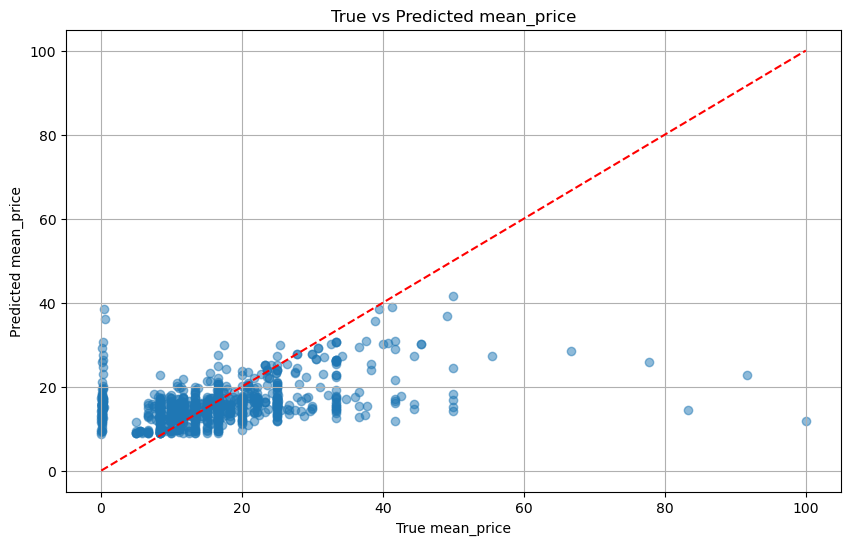

In [5841]:
plt.figure(figsize=(10, 6))
plt.scatter(y_train_test, y_pred_best_xgbrf, alpha=0.5)
plt.plot([min(y_train_test), max(y_train_test)], 
         [min(y_train_test), max(y_train_test)], 'r--')
plt.xlabel('True mean_price')
plt.ylabel('Predicted mean_price')
plt.title('True vs Predicted mean_price')
plt.grid(True)
plt.show()

In [5854]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR

def optimize_svr(trial):
    # Определяем параметры
    kernel = trial.suggest_categorical('kernel', [
        'linear',
        'rbf',
        'poly'
        ]) 
    params = {
        'C': trial.suggest_float('C', 0.1, 1000, log=True),
        'epsilon': trial.suggest_float('epsilon', 1e-4, 1, log=True),
        'kernel': kernel,
    }
    
    if kernel in ['rbf', 'poly']:
        params['gamma'] = trial.suggest_float('gamma', 1e-5, 10, log=True)
    
    if kernel == 'poly':
        params['degree'] = trial.suggest_int('degree', 2, 5)
    
    params['cache_size'] = 1000
    params['max_iter'] = 10000
    
    r2_scores = cross_val_score(
        SVR(**params), X_train_train, y_train_train, 
        cv=CV_FOLDS_SVR, 
        scoring='r2', 
        n_jobs=-1,
        error_score='raise'
    )
    
    return np.mean(r2_scores)

In [5855]:
study_svr = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42)
)
study_svr.optimize(optimize_svr, n_trials=N_TRIALS_SVR)

[I 2025-06-14 03:23:17,663] A new study created in memory with name: no-name-038449ee-c239-45f3-8b99-3a39bc3a1e6e
[I 2025-06-14 03:23:18,074] Trial 0 finished with value: 0.070940435128882 and parameters: {'kernel': 'rbf', 'C': 24.81040974867809, 'epsilon': 0.00042079886696066364, 'gamma': 8.629132190071849e-05}. Best is trial 0 with value: 0.070940435128882.
[I 2025-06-14 03:23:18,595] Trial 1 finished with value: 0.0835033621304185 and parameters: {'kernel': 'rbf', 'C': 67.9657809075815, 'epsilon': 0.00012087541473056971, 'gamma': 6.5987110720540665}. Best is trial 1 with value: 0.0835033621304185.
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider

Результаты плохие, продолжать не имеет смысла.

Анализ моделей

In [5856]:
metrics_comparisson = {
    "RF": final_metrics_rf,
    "XGB": final_metrics_xgb,
    "XGBRF": final_metrics_xgbrf
}

df_metrics = pd.DataFrame(metrics_comparisson)

/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*pl

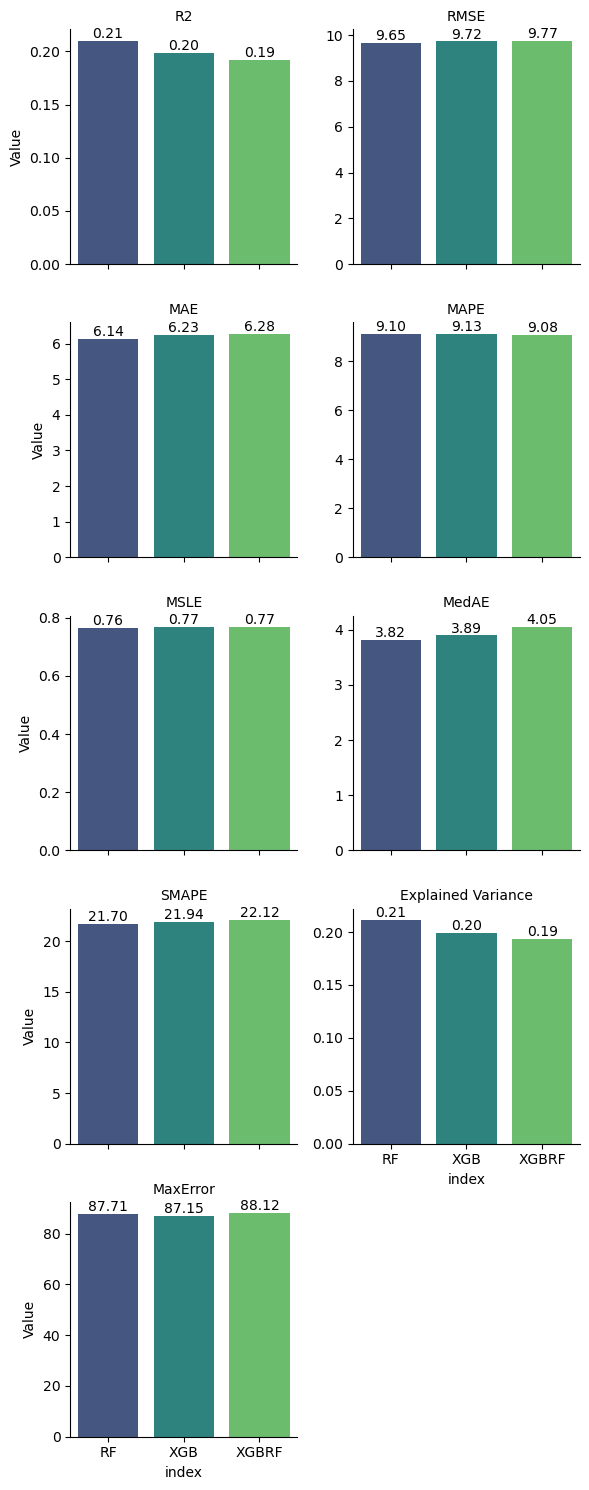

In [5857]:
plot_data = df_metrics.T.reset_index().melt(id_vars='index', var_name='Metric', value_name='Value')

palette = sns.color_palette("viridis", n_colors=len(plot_data['index'].unique()))

g = sns.FacetGrid(plot_data, col="Metric", col_wrap=2, sharey=False)
g.map_dataframe(sns.barplot, x="index", y="Value", palette=palette, ci=None)
g.set_titles("{col_name}")

for ax in g.axes:
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}", 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

g.tight_layout()
plt.show()

Различия небольшие, random forest минимально лучше

## Предикт на тесте

In [5859]:
final_model = RandomForestRegressor(
    **study_rf.best_params,
    random_state=42,
    n_jobs=-1
)
final_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_depth=14, max_features='log2',
                      min_samples_leaf=3, n_estimators=658, n_jobs=-1,
                      random_state=42)

In [5865]:
predictions = final_model.predict(test)
df = pd.DataFrame({"mean_price": predictions})

In [5868]:
df.to_csv("homework_4_data/submission.csv", index_label="index")